In [1]:
import tensorflow as tf
import numpy as np
import ast
import cv2
import json
import network_rnn as net
import math
import collections
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img_width = 112#112
network_output_width = 14#14
vgg_3d_channel = 32
def video_anno_data_using_make_file_batch(video_path, anno_path, step_size = 60):
    batch_size = len(video_path)
    width = img_width
    height = img_width
    channel = 3
    
    video = []
    anno = []
    
    for i in range(batch_size):
        #print("hello")
        anno_tmp, video_tmp = load_data(anno_path[i], video_path[i])
        #rint("hello")
        anno.append(anno_tmp)
        video.append(video_tmp)
        
    return video, anno
        
def make_file_batch(batch_size = 1):
    video_path = './video_with_abstacle/TrainingSet_2/3/'
    anno_path = './video_with_abstacle/TrainingSet_2/4/'
    
    video_list = os.listdir(video_path)
    anno_list = os.listdir(anno_path)
    
    video_list.sort()
    anno_list.sort()
    
    num_of_data = len(video_list)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_video_path = [video_path +'/'+ video_list[i] for i in index]
    shuffled_anno_path = [anno_path +'/'+ anno_list[j] for j in index]
    
    return np.asarray(shuffled_video_path), np.asarray(shuffled_anno_path)
def make_test_batch(batch_size = 1):
    video_path = './video_with_abstacle/TrainingSet_2/3'
    anno_path = './video_with_abstacle/TrainingSet_2/4'
    
    video_list = os.listdir(video_path)
    anno_list = os.listdir(anno_path)
    
    video_list.sort()
    anno_list.sort()
    
    num_of_data = len(video_list)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_video_path = [video_path +'/'+ video_list[i] for i in index]
    shuffled_anno_path = [anno_path +'/'+ anno_list[j] for j in index]
    print("test video : ",shuffled_video_path)
    return np.asarray(shuffled_video_path), np.asarray(shuffled_anno_path)

def _put_heatmap_on_plane(heatmap, plane_idx, joint, sigma, height, width, stride):
    start = stride / 2.0 - 0.5

    center_x, center_y = joint

    for g_y in range(height):
        for g_x in range(width):
            x = start + g_x * stride
            y = start + g_y * stride
            d2 = (x-center_x) * (x-center_x) + (y-center_y) * (y-center_y)
            exponent = d2 / 2.0 / sigma / sigma
            if exponent > 4.6052:
                continue

            heatmap[g_y, g_x, plane_idx] += math.exp(-exponent)
            if heatmap[g_y, g_x, plane_idx] > 1.0:
                heatmap[g_y, g_x, plane_idx] = 1.0
                
                
def _put_paf_on_plane(vectormap, countmap, plane_idx, center_from, center_to, threshold, height, width, stride):
    center_from = (center_from[0] // stride, center_from[1] // stride)
    center_to = (center_to[0] // stride, center_to[1] // stride)

    vec_x = center_to[0] - center_from[0]
    vec_y = center_to[1] - center_from[1]

    min_x = max(0, int(min(center_from[0], center_to[0]) - threshold))
    min_y = max(0, int(min(center_from[1], center_to[1]) - threshold))

    max_x = min(width, int(max(center_from[0], center_to[0]) + threshold))
    max_y = min(height, int(max(center_from[1], center_to[1]) + threshold))

    norm = math.sqrt(vec_x ** 2 + vec_y ** 2)
    if norm < 1e-8: #1e-8 이하는 0으로 인식되서 0으로 나눌수 없다는 에러 발생. 따라서 return처리 해줌
        return

    vec_x /= norm
    vec_y /= norm
    
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            bec_x = x - center_from[0]
            bec_y = y - center_from[1]
            dist = abs(bec_x * vec_y - bec_y * vec_x)

            if dist > threshold:
                continue

            countmap[x][y][plane_idx] = countmap[x][y][plane_idx] + 1

            vectormap[x][y][plane_idx*2+0] = vec_x
            vectormap[x][y][plane_idx*2+1] = vec_y
            

def bubble_sort(L):
    for i in range(len(L)-1):
        for j in range(len(L)-1):
            if L[j] > L[j+1]:
                temp = L[j+1]
                L[j+1] = L[j]
                L[j] = temp

def load_data(anno_path, video_path):#아직은 annotation data만 load
    #Annotation Data Load
    f = open(anno_path)
    
    s = f.readlines()

    file_name = []
    parts = []
    _joint_data = []

    
    file_path = []
    joint_data = []
    for index, data in enumerate(s):
        #print(i)
        raw_data = ast.literal_eval(data)
        #print(raw_data)
        raw_data = json.loads(raw_data)
        joint_data.append(raw_data)
    #print(joint_data[0])
    
    heatmap_height = network_output_width
    heatmap_width = network_output_width
    index = 0
    for j in joint_data:
        #print(j)
        height = img_width
        width = img_width
        if(j == {}):
            pass
        else:
            array = j.keys()
            #print(array)
            #print(j)
            for k in array:
                joint_data[index][k][0] = int(j[k][0] / height / 3.17 * heatmap_height)
                joint_data[index][k][1] = int(j[k][1] / width / 3.17 * heatmap_width)#3.17 -> 356/112
                #print(j[k][0], j[k][1])
        index = index + 1
    
    #Video Data Load
    cap = cv2.VideoCapture(video_path)
    video_data = []
    i = 0
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    while(i != length):
        ret, frame = cap.read()
        #gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (img_width, img_width))
        video_data.append(frame)
        i = i + 1
    return joint_data, video_data

In [3]:
class openpose():
    def __init__(self, batch_size, sess):
        self.sess = sess
        num_frame = 60
        self.X = tf.placeholder(dtype=tf.float32, shape=[num_frame, img_width, img_width, 3])
        self.confidence_map_label = tf.placeholder(dtype=tf.float32, shape=[num_frame, network_output_width, network_output_width, 17])
        self.vector_map_label = tf.placeholder(dtype=tf.float32, shape=[num_frame, network_output_width, network_output_width, 34])
        self.batch_size = batch_size
        print("test data load start")
        #self.test_image_path = self.load_test_data()
        print("test data load finish")

        self.model()
        self.optimizer()
        print("open pose init complete")
        
    def load_test_data(self):
        img_path = "./MPII_Dataset/resized_test_image/"
        file_path = []
        file_list = os.listdir(img_path)
        for i in (file_list):
            file_path.append(img_path + i)
        return file_path
        
    
    def make_heatmap(self, anno_data, width = network_output_width, height = network_output_width, num_of_maps = 17):
        batch_size = len(anno_data)
        width = network_output_width
        height = network_output_width
        num_of_maps = 17

        output = np.zeros((batch_size, width, height, num_of_maps))
        for index, joints in enumerate(anno_data):
            #print(len(anno_data))
            #print(index)
            #joint_data = anno_data
            heatmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌
            #print(joints)

            buffer = list(joints.items())
            key_buffer = joints.keys()

            for i in range(len(buffer)):
                buffer[i] = list(buffer[i])
                buffer[i][0] = int(buffer[i][0])
            bubble_sort(buffer)

            idx = 0
            for j in range(17):
                if('%d' %j in key_buffer):
                    center_x = buffer[idx][1][0]
                    center_y = buffer[idx][1][1]
                    #joint = buffer[idx][1]
                    joint = [center_y, center_x]
                    idx = idx + 1
                    _put_heatmap_on_plane(heatmap, plane_idx = j, joint = joint, sigma = 3, height = height, \
                                          width = width, stride = 1)
                else:
                    pass
            idx = 0
            heatmap[:, :, -1] = np.clip(1.0 - np.amax(heatmap, axis=2), 0.0, 1.0)
            output[index] = heatmap
            #print("make_heatmap's output shape : ", np.shape(output))
            #output -> frame, width, height, channel
            output2 = np.transpose(output, [0, 3, 2, 1])
        return output2
        
    
    def make_paf_field(self, batch_joint_data, width = network_output_width, height = network_output_width, num_of_maps = 17):
        batch_size = len(batch_joint_data)
        output1 = np.zeros((batch_size, width, height, num_of_maps*2))
        output2 = np.zeros((batch_size, width, height, num_of_maps))
        for index, joints in enumerate(batch_joint_data):
            joint_pairs = list(zip(
                [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1],
                [8,13,12, 7,14,15,11,10,6,3,2,4,5,1,0]))
            #make vector map
            width = network_output_width
            height = network_output_width
            num_of_maps = 17
            vectormap = np.zeros((width, height, num_of_maps*2), dtype=np.float32)#batch 일단 뺌
            countmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

            key = (joints.keys())
            for plane_idx, (j_idx1, j_idx2) in enumerate(joint_pairs):
                if(('%d' %j_idx1 in key) and ('%d' %j_idx2 in key)):

                    center_from = joints['%d'%j_idx1]
                    center_to = joints['%d'%j_idx2]

                    if not center_from or not center_to:
                        continue
                    _put_paf_on_plane(vectormap=vectormap, countmap=countmap, plane_idx=plane_idx, center_from=center_from, center_to=center_to, \
                                      threshold=1, height=network_output_width, width=network_output_width, stride = 1)

            nonzeros = np.nonzero(countmap)


            for x, y, p in zip(nonzeros[0], nonzeros[1], nonzeros[2]):
                if countmap[x][y][p] <= 0:
                    continue
                vectormap[x][y][p*2+0] /= countmap[x][y][p]
                vectormap[x][y][p*2+1] /= countmap[x][y][p]

            output1[index] = vectormap.astype(np.float32)
            output2[index] = countmap
        return output1, output2 #output1 -> vectormap, output2 -> countmap


        
    
    def model(self):

        #(self.X)
        stage0_data = net.block_2d_vgg_19(self.X)#stage0_data - None, frame, 14, 14, 32
        #stage0_data 's shape -> None, 60, 14*14*16
        self.vgg_output = stage0_data
        hidden_size = network_output_width*network_output_width*vgg_3d_channel

        cell = tf.contrib.rnn.GRUCell(hidden_size)
        initial_state = cell.zero_state(batch_size=self.batch_size, dtype=tf.float32)

        
        reshaped_stage0_data = tf.reshape(stage0_data, [-1, 60, network_output_width*network_output_width*vgg_3d_channel])
        output, state = tf.nn.dynamic_rnn(cell = cell, inputs = reshaped_stage0_data, \
                                          dtype = tf.float32, initial_state=initial_state)
        
        print("RNN output's shape : ", np.shape(output))
        #tf.contrib.
        stage0_data = tf.reshape(output, [60, network_output_width, network_output_width, vgg_3d_channel])
        print("RNN reshaped output's shape : ", np.shape(stage0_data))

        self.stage1_branch1 = net.block_2d_stage_1_branch1(stage0_data)#stage1_branch1 - None, frame, 44, 44, 34        
        self.stage1_branch2 = net.block_2d_stage_1_branch2(stage0_data)#stage1_branch2 - None, frame, 44, 44, 17
        self.stage1_data = tf.concat([self.stage1_branch1, self.stage1_branch2, stage0_data], 3)
        ##########################################################################################################
        self.stage2_branch1 = net.block_2d_stage_2_branch1(self.stage1_data)#stage2_branch1 - None, frame, 44, 44, 34
        self.stage2_branch2 = net.block_2d_stage_2_branch2(self.stage1_data)#stage2_branch2 - None, frame, 44, 44, 17
        self.stage2_data = tf.concat([self.stage2_branch1, self.stage2_branch2, stage0_data], 3)
        ##########################################################################################################
        self.stage3_branch1 = net.block_2d_stage_3_branch1(self.stage2_data)#stage2_branch1 - None, frame, 44, 44, 34
        self.stage3_branch2 = net.block_2d_stage_3_branch2(self.stage2_data)#stage2_branch2 - None, frame, 44, 44, 17
        self.stage3_data = tf.concat([self.stage3_branch1, self.stage3_branch2, stage0_data], 3)
        ##########################################################################################################
        self.stage4_branch1 = net.block_2d_stage_4_branch1(self.stage3_data)#stage2_branch1 - None, frame, 44, 44, 34
        self.stage4_branch2 = net.block_2d_stage_4_branch2(self.stage3_data)#stage2_branch2 - None, frame, 44, 44, 17
        self.stage4_data = tf.concat([self.stage4_branch1, self.stage4_branch2, stage0_data], 3)
        ##########################################################################################################
        self.stage5_branch1 = net.block_2d_stage_5_branch1(self.stage4_data)#stage2_branch1 - None, frame, 44, 44, 34
        self.stage5_branch2 = net.block_2d_stage_5_branch2(self.stage4_data)#stage2_branch2 - None, frame, 44, 44, 17
        self.stage5_data = tf.concat([self.stage5_branch1, self.stage5_branch2, stage0_data], 3)
        ##########################################################################################################
        self.stage6_branch1 = net.block_2d_stage_6_branch1(self.stage5_data)#stage2_branch1 - None, frame, 44, 44, 34
        self.stage6_branch2 = net.block_2d_stage_6_branch2(self.stage5_data)#stage2_branch2 - None, frame, 44, 44, 17
        self.stage6_data = tf.concat([self.stage6_branch1, self.stage6_branch2, stage0_data], 3)
        ##########################################################################################################
        #self.stage7_branch1 = net.block_3d_stage_7_branch1(self.stage6_data)#stage2_branch1 - None, frame, 44, 44, 34
        #self.stage7_branch2 = net.block_3d_stage_7_branch2(self.stage6_data)#stage2_branch2 - None, frame, 44, 44, 17
        #self.stage7_data = tf.concat([self.stage7_branch1, self.stage7_branch2, stage0_data], 4)
        ##########################################################################################################
        #self.stage8_branch1 = net.block_3d_stage_8_branch1(self.stage7_data)#stage2_branch1 - None, frame, 44, 44, 34
        #self.stage8_branch2 = net.block_3d_stage_8_branch2(self.stage7_data)#stage2_branch2 - None, frame, 44, 44, 17
        #self.stage8_data = tf.concat([self.stage8_branch1, self.stage8_branch2, stage0_data], 4)
        ##########################################################################################################
        #self.stage9_branch1 = net.block_3d_stage_9_branch1(self.stage8_data)#stage2_branch1 - None, frame, 44, 44, 34
        #self.stage9_branch2 = net.block_3d_stage_9_branch2(self.stage8_data)#stage2_branch2 - None, frame, 44, 44, 17
        #self.stage9_data = tf.concat([self.stage9_branch1, self.stage9_branch2, stage0_data], 4)
        ##########################################################################################################
    def optimizer(self):
        
        W_p = 1
        #loss는 euclid loss 함수 사용
        #affinity field loss - branch1
        self.loss_stage1_branch1 = tf.nn.l2_loss(W_p*(self.stage1_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage2_branch1 = tf.nn.l2_loss(W_p*(self.stage2_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage3_branch1 = tf.nn.l2_loss(W_p*(self.stage3_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage4_branch1 = tf.nn.l2_loss(W_p*(self.stage4_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage5_branch1 = tf.nn.l2_loss(W_p*(self.stage5_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage6_branch1 = tf.nn.l2_loss(W_p*(self.stage6_branch1 - self.vector_map_label)) / self.batch_size
        #self.loss_stage7_branch1 = tf.nn.l2_loss(W_p*(self.stage7_branch1 - self.vector_map_label)) / self.batch_size
        #self.loss_stage8_branch1 = tf.nn.l2_loss(W_p*(self.stage8_branch1 - self.vector_map_label)) / self.batch_size
        #self.loss_stage9_branch1 = tf.nn.l2_loss(W_p*(self.stage9_branch1 - self.vector_map_label)) / self.batch_size
        
        #confidence map loss - branch2
        self.loss_stage1_branch2 = tf.nn.l2_loss(W_p*(self.stage1_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage2_branch2 = tf.nn.l2_loss(W_p*(self.stage2_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage3_branch2 = tf.nn.l2_loss(W_p*(self.stage3_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage4_branch2 = tf.nn.l2_loss(W_p*(self.stage4_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage5_branch2 = tf.nn.l2_loss(W_p*(self.stage5_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage6_branch2 = tf.nn.l2_loss(W_p*(self.stage6_branch2 - self.confidence_map_label)) / self.batch_size
        #self.loss_stage7_branch2 = tf.nn.l2_loss(W_p*(self.stage7_branch2 - self.confidence_map_label)) / self.batch_size
        #self.loss_stage8_branch2 = tf.nn.l2_loss(W_p*(self.stage8_branch2 - self.confidence_map_label)) / self.batch_size
        #self.loss_stage9_branch2 = tf.nn.l2_loss(W_p*(self.stage9_branch2 - self.confidence_map_label)) / self.batch_size
                
        #rnn network loss
        
        self.loss1 = tf.reduce_mean([self.loss_stage1_branch1, self.loss_stage1_branch2])
        self.loss2 = tf.reduce_mean([self.loss_stage2_branch1, self.loss_stage2_branch2])
        self.loss3 = tf.reduce_mean([self.loss_stage3_branch1, self.loss_stage3_branch2])
        self.loss4 = tf.reduce_mean([self.loss_stage4_branch1, self.loss_stage4_branch2])
        self.loss5 = tf.reduce_mean([self.loss_stage5_branch1, self.loss_stage5_branch2])
        self.loss6 = tf.reduce_mean([self.loss_stage6_branch1, self.loss_stage6_branch2])
        #self.loss7 = tf.reduce_mean([self.loss_stage7_branch1, self.loss_stage7_branch2])
        #self.loss8 = tf.reduce_mean([self.loss_stage8_branch1, self.loss_stage8_branch2])
        #self.loss9 = tf.reduce_mean([self.loss_stage9_branch1, self.loss_stage9_branch2])
        
        self.total_loss = (self.loss1 + self.loss2 + self.loss3 + self.loss4 + self.loss5 + self.loss6) / self.batch_size
        #self.total_loss = (self.loss1 + self.loss2 + self.loss3 + self.loss4 + self.loss5 + self.loss6 + self.loss7\
        #                  + self.loss8 + self.loss9) / self.batch_size
        
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 4e-3#4e-5
        lr = tf.train.exponential_decay(starter_learning_rate, global_step,4000, 0.333, staircase=True)#100000->5000
        self.optimizer_total_loss = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.total_loss, global_step=global_step)
        

    def train(self):
        data_size = 1562#41749
        num_video_frame = 60
        batch_size = self.batch_size
        total_batch = int(data_size / batch_size)

        h_loss_data = []
        v_loss_data = []
        graph_loss_iter1 = []
        graph_loss_iter2 = []
        
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_rnn/Weight.ckpt"
        print("graph init start")
        self.sess.run(tf.global_variables_initializer())
        print("graph init finish")
        saver = tf.train.Saver()

        try:
            saver.restore(self.sess, SAVE_PATH)
            print("----------------Weight load----------------")
        except:
            print("---------------No Weight Exist---------------")
            print("----------------Training Start---------------")
        
        iteration = 0
        for epoch in range(10000):#15
            print("epoch",epoch+1, "start")
            loss_iter1 = 0
            loss_iter2 = 0
            
            for i in range(10):#total_batch
                #여기 앞에까진 1.json 에 대한 annotation data 생성 완료. batch 를 할 필요
                #data load, batch 생성
                
                _batch_video_path, _batch_anno_path = make_file_batch(batch_size)
                _batch_video_data, _batch_anno_data = \
                video_anno_data_using_make_file_batch(_batch_video_path, _batch_anno_path, num_video_frame)
                #_batch_video_data, _batch_anno_data가 training에 사용됨
                #_batch_video_data -> [batch, frame_size, width, height, channel]
                #_batch_anno_data가 -> [batch, ]
                
                #[batch, frame_size, width, height, channel]을 [frame_size, batch, width, height, channel]로 변경
                
                _transposed_batch_video_data = np.transpose(_batch_video_data, [1,0,2,3,4])
                _transposed_batch_anno_data = np.transpose(_batch_anno_data, [1,0])
                
                data = np.zeros((batch_size, num_video_frame, img_width, img_width, 3), dtype=np.float32)
                for batch in range(batch_size):
                    for frame in range(num_video_frame):
                        data[batch][frame] = (_batch_video_data[batch][frame].astype(np.float32) / 256.0)
                        
                _heatmap = []
                _vectormap = []
                _countmap = []
                data_squeeze = np.squeeze(data)
                for j in range(num_video_frame):
                    heatmap = self.make_heatmap(_transposed_batch_anno_data[j], width=14, height=14, num_of_maps=17)
                    vectormap, countmap = self.make_paf_field(_transposed_batch_anno_data[j], width = 14, height = 14, num_of_maps = 17)

                    _heatmap.append(heatmap)
                    _vectormap.append(vectormap)
                    _countmap.append(countmap)
                #print("_heatmap's shape : ", np.shape(_heatmap))
                transpose_heatmap = np.transpose(_heatmap, [1,0,4,3,2])#3, 4, 2
                #print("transpose_heatmap's shape : ", np.shape(transpose_heatmap))
                transpose_vectormap = np.transpose(_vectormap, [1,0,2,3,4])
                transpose_countmap = np.transpose(_countmap, [1,0,2,3,4])
                
                vectormap_squeeze = np.squeeze(transpose_vectormap)
                heatmap_squeeze = np.squeeze(transpose_heatmap)
                
                #print("data_squeeze : ", np.shape(data_squeeze))
                #print("vectormap, countmap : ", np.shape(transpose_vectormap), np.shape(transpose_heatmap))
                total_loss_opt, Heat_loss, Vector_loss = \
                self.sess.run([self.optimizer_total_loss, self.loss_stage6_branch1, self.loss_stage6_branch2],
                              #_batch_video_data
                         feed_dict = {self.X : data_squeeze, \
                                      self.confidence_map_label : heatmap_squeeze, \
                                      self.vector_map_label : vectormap_squeeze})

                h_loss_data.append(Heat_loss)
                v_loss_data.append(Vector_loss)
                loss_iter1 = loss_iter1 + Heat_loss
                loss_iter2 = loss_iter2 + Vector_loss
                iteration = iteration + 1
                
            loss_iter1 = loss_iter1 / 10#total_batch
            loss_iter2 = loss_iter2 / 10#total_batch
            
            graph_loss_iter1.append(loss_iter1)
            graph_loss_iter2.append(loss_iter2)
            
            print("heatmap cost")
            print("Heat_loss : ", Heat_loss)
            print("vectormap cost")
            print("Vector_loss : ", Vector_loss)
            print('\n')
            print("avg'Heat_loss : ", loss_iter1)
            print("avg'Vector_loss : ", loss_iter2)
            

            
            np.savez("./Loss/heat_loss.npz", iteration, graph_loss_iter1)
            np.savez("./Loss/vector_loss.npz", iteration, graph_loss_iter2)
            
            plt.plot(graph_loss_iter1)
            plt.show()
            plt.plot(graph_loss_iter2)
            plt.show()
            plt.plot(h_loss_data)
            plt.show()
            plt.plot(v_loss_data)
            plt.show()
            saver.save(self.sess, SAVE_PATH)
        #return batch_img, batch_img_path, batch_annotation, heatmap, vectormap, countmap
        #return self.image_path, self.annotation_data

        
    def test(self):
        batch_size = self.batch_size
        num_video_frame = 60
        _batch_video_path, _batch_anno_path = make_test_batch(batch_size)
        _batch_video_data, _batch_anno_data = \
        video_anno_data_using_make_file_batch(_batch_video_path, _batch_anno_path, num_video_frame)
        
        data = np.zeros((batch_size, num_video_frame, img_width, img_width, 3), dtype=np.float32)
        for batch in range(batch_size):
            for frame in range(num_video_frame):
                data[batch][frame] = (_batch_video_data[batch][frame].astype(np.float32) / 256.0)
        
        
        data_squeeze = np.squeeze(data)
        #vectormap_squeeze = np.squeeze(transpose_vectormap)
        #heatmap_squeeze = np.squeeze(transpose_heatmap)
        
        
        
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_rnn/Weight.ckpt"
        print("graph init start")
        self.sess.run(tf.global_variables_initializer())
        print("graph init finish")
        saver = tf.train.Saver()

        saver.restore(self.sess, SAVE_PATH)
        print("----------------Weight load----------------")
        
        paf, heatmap, vgg_output = self.sess.run([self.stage6_branch1, self.stage6_branch2, self.vgg_output], feed_dict = {self.X : data_squeeze})
        return paf, heatmap, vgg_output

        
    def data_test(self):
        data_size = 1562#41749
        num_video_frame = 60
        batch_size = self.batch_size
        total_batch = int(data_size / batch_size)

        
        for epoch in range(1):#15
            print("epoch",epoch+1, "start")
            for i in range(1):#total_batch
                #여기 앞에까진 1.json 에 대한 annotation data 생성 완료. batch 를 할 필요
                #data load, batch 생성
                _batch_video_path, _batch_anno_path = make_test_batch(batch_size)
                _batch_video_data, _batch_anno_data = \
                video_anno_data_using_make_file_batch(_batch_video_path, _batch_anno_path, num_video_frame)
                #_batch_video_data, _batch_anno_data가 training에 사용됨
                #_batch_video_data -> [batch, frame_size, width, height, channel]
                #_batch_anno_data -> [batch, ]
                
                #[batch, frame_size, width, height, channel]을 [frame_size, batch, width, height, channel]로 변경
                
                _transposed_batch_video_data = np.transpose(_batch_video_data, [1,0,2,3,4])
                _transposed_batch_anno_data = np.transpose(_batch_anno_data, [1,0])
                
                _heatmap = []
                _vectormap = []
                _countmap = []
                
                for j in range(num_video_frame):
                    heatmap = self.make_heatmap(_transposed_batch_anno_data[j], width=network_output_width, height=network_output_width, num_of_maps=17)
                    vectormap, countmap = self.make_paf_field(_transposed_batch_anno_data[j], width = network_output_width, height = network_output_width, num_of_maps = 17)
                    _heatmap.append(heatmap)
                    _vectormap.append(vectormap)
                    _countmap.append(countmap)
                print("sol1 : ", np.shape(_heatmap))
                print("sol2 : ", np.shape(_vectormap))
                transpose_heatmap = np.transpose(_heatmap, [1,0,3,4,2])
                transpose_vectormap = np.transpose(_vectormap, [1,0,2,3,4])
                transpose_countmap = np.transpose(_countmap, [1,0,2,3,4])

        return _batch_video_data, transpose_heatmap, transpose_vectormap, transpose_countmap, _transposed_batch_anno_data
        #return self.image_path, self.annotation_data

        


    
print("cell end")

cell end


Training Session

test data load start
test data load finish
RNN output's shape :  (1, 60, 6272)
RNN reshaped output's shape :  (60, 14, 14, 32)
open pose init complete
graph init start
graph init finish
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_rnn/Weight.ckpt
---------------No Weight Exist---------------
----------------Training Start---------------
epoch 1 start
heatmap cost
Heat_loss :  194513.78
vectormap cost
Vector_loss :  103615.28


avg'Heat_loss :  198258.265625
avg'Vector_loss :  104549.68125


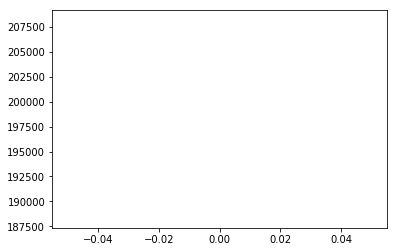

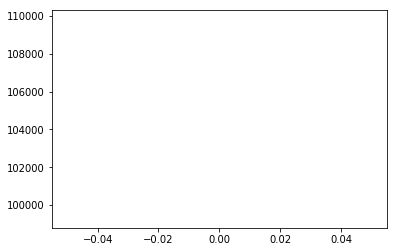

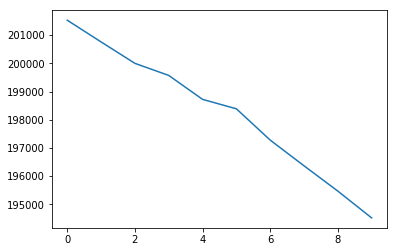

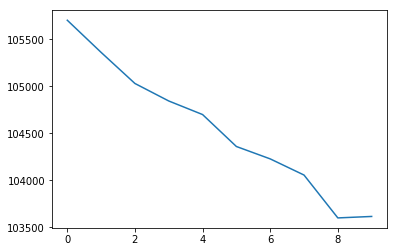

epoch 2 start
heatmap cost
Heat_loss :  116772.43
vectormap cost
Vector_loss :  98517.08


avg'Heat_loss :  170703.50859375
avg'Vector_loss :  100679.740625


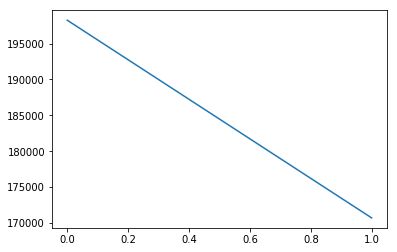

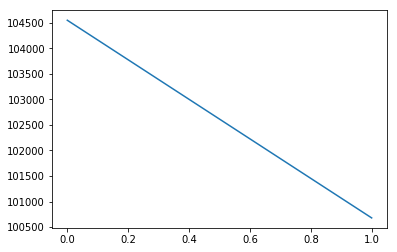

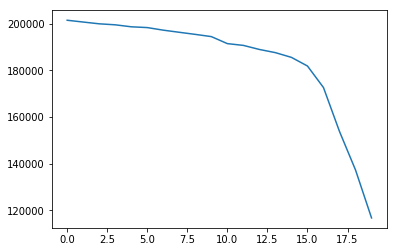

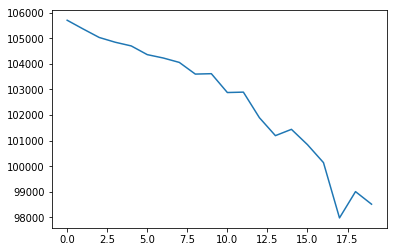

epoch 3 start
heatmap cost
Heat_loss :  73657.87
vectormap cost
Vector_loss :  75771.95


avg'Heat_loss :  84158.84453125
avg'Vector_loss :  85976.30625


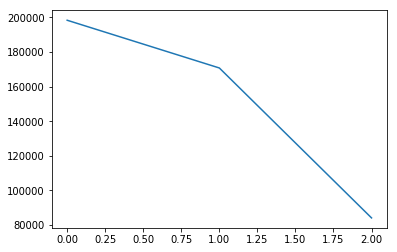

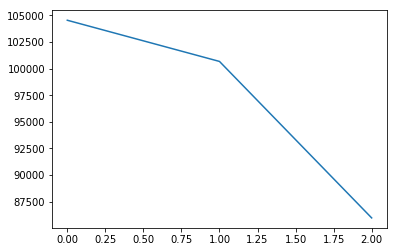

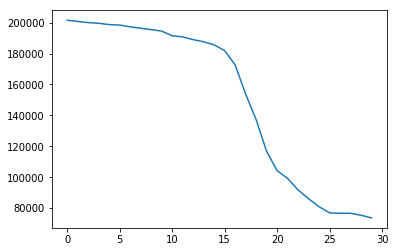

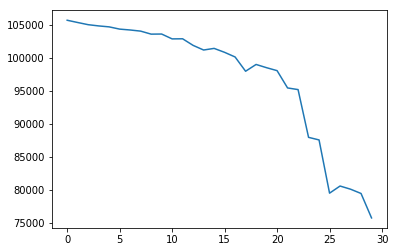

epoch 4 start
heatmap cost
Heat_loss :  60330.566
vectormap cost
Vector_loss :  18631.58


avg'Heat_loss :  67544.38125
avg'Vector_loss :  39970.9615234375


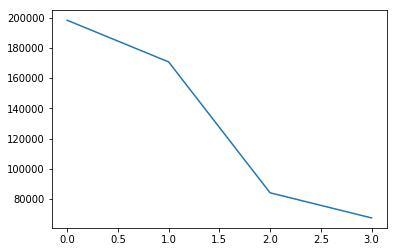

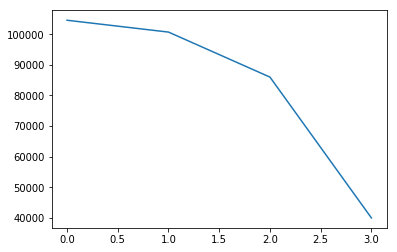

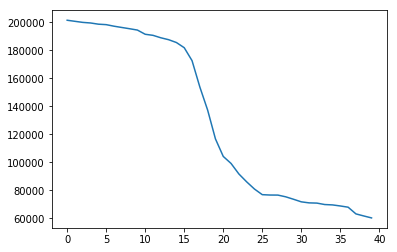

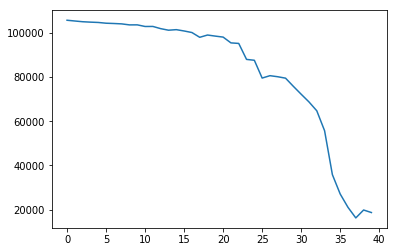

epoch 5 start
heatmap cost
Heat_loss :  44022.508
vectormap cost
Vector_loss :  8968.826


avg'Heat_loss :  51261.439453125
avg'Vector_loss :  9893.91015625


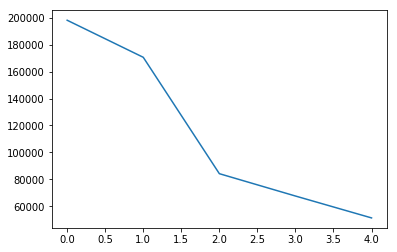

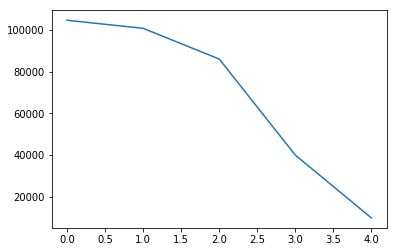

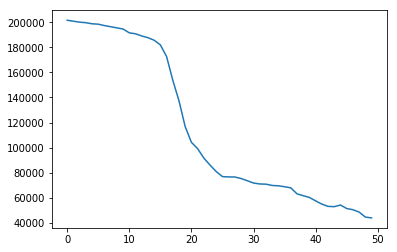

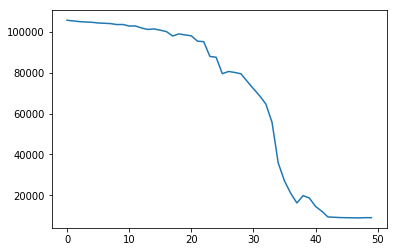

epoch 6 start
heatmap cost
Heat_loss :  29999.387
vectormap cost
Vector_loss :  8419.558


avg'Heat_loss :  37133.0740234375
avg'Vector_loss :  8658.980078125


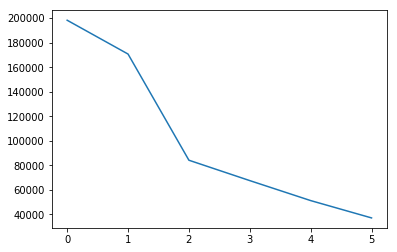

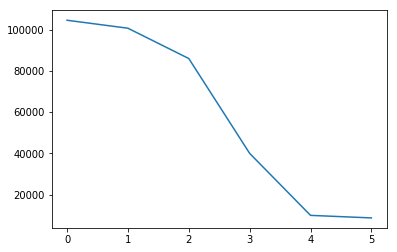

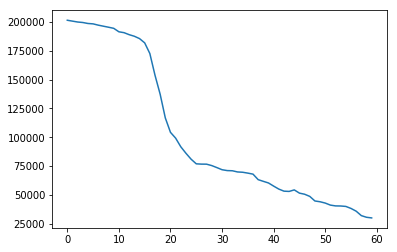

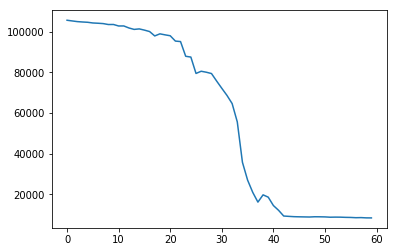

epoch 7 start
heatmap cost
Heat_loss :  29371.902
vectormap cost
Vector_loss :  8068.3364


avg'Heat_loss :  29715.0888671875
avg'Vector_loss :  8239.920361328124


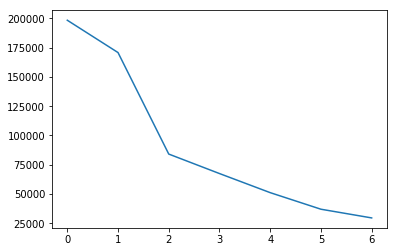

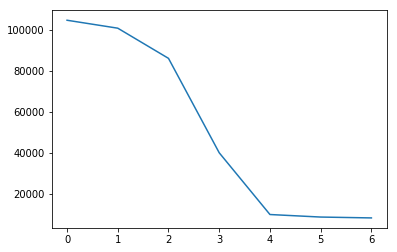

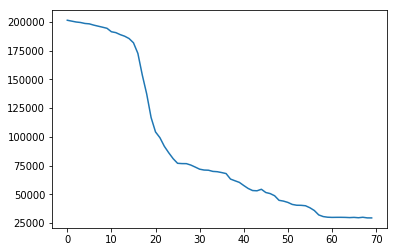

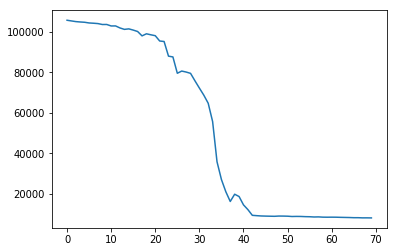

epoch 8 start
heatmap cost
Heat_loss :  25834.469
vectormap cost
Vector_loss :  7713.354


avg'Heat_loss :  28248.680078125
avg'Vector_loss :  7867.006494140625


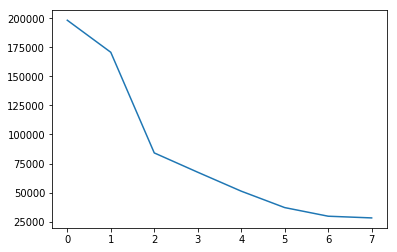

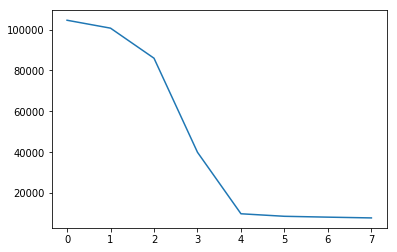

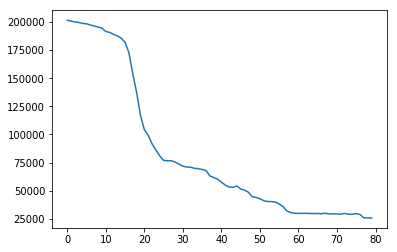

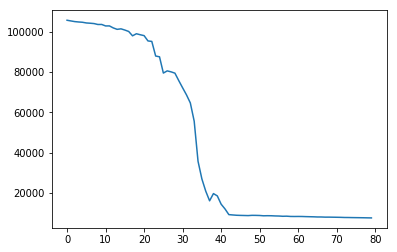

epoch 9 start
heatmap cost
Heat_loss :  25358.344
vectormap cost
Vector_loss :  7408.5747


avg'Heat_loss :  25696.402734375
avg'Vector_loss :  7545.58486328125


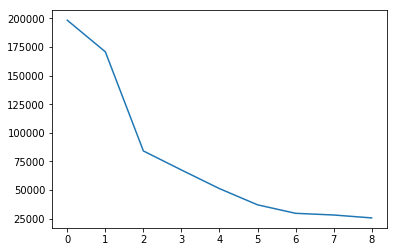

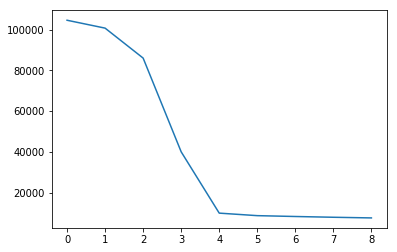

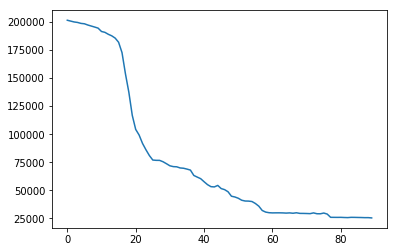

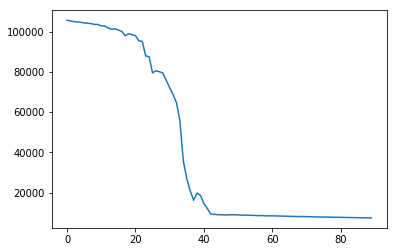

epoch 10 start
heatmap cost
Heat_loss :  19804.828
vectormap cost
Vector_loss :  7168.592


avg'Heat_loss :  20342.7599609375
avg'Vector_loss :  7281.451904296875


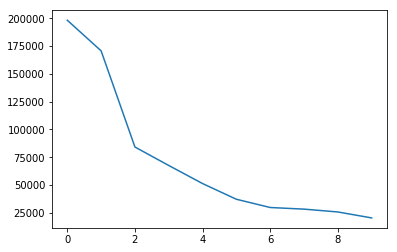

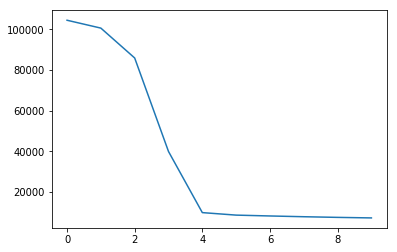

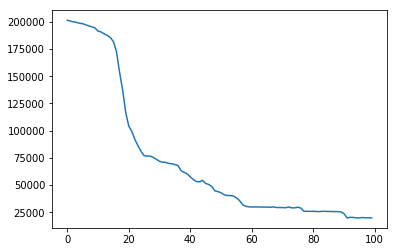

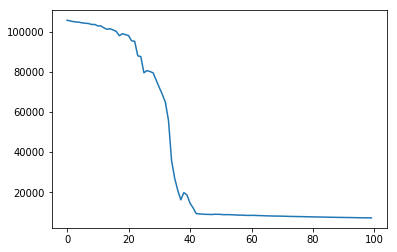

epoch 11 start
heatmap cost
Heat_loss :  19387.848
vectormap cost
Vector_loss :  6960.8057


avg'Heat_loss :  19754.9572265625
avg'Vector_loss :  7046.99052734375


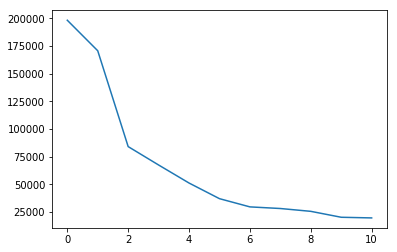

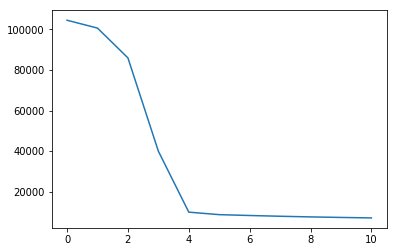

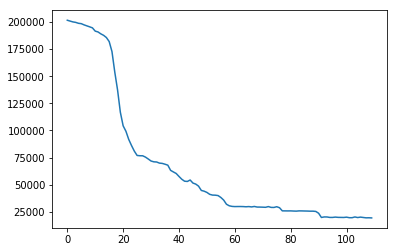

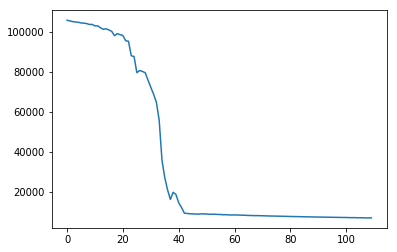

epoch 12 start
heatmap cost
Heat_loss :  20662.625
vectormap cost
Vector_loss :  6777.5967


avg'Heat_loss :  20642.8052734375
avg'Vector_loss :  6838.302685546875


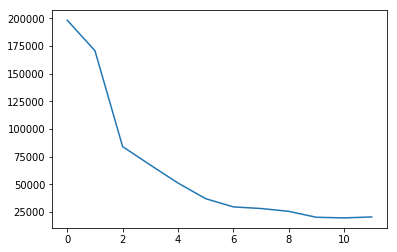

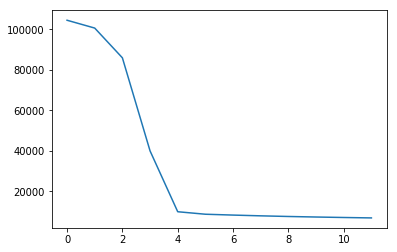

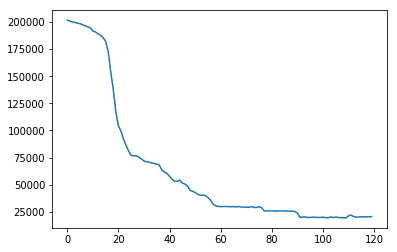

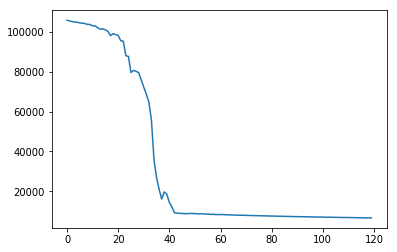

epoch 13 start
heatmap cost
Heat_loss :  20828.957
vectormap cost
Vector_loss :  6662.2974


avg'Heat_loss :  20302.98515625
avg'Vector_loss :  6624.722314453125


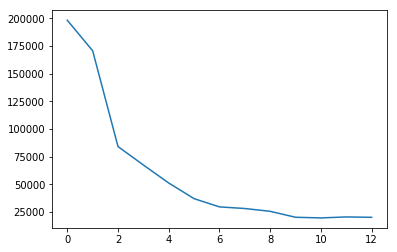

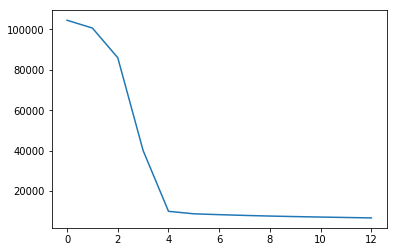

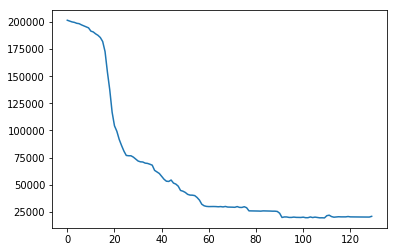

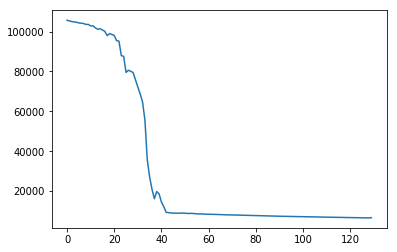

epoch 14 start
heatmap cost
Heat_loss :  20490.492
vectormap cost
Vector_loss :  6340.1997


avg'Heat_loss :  20310.728125
avg'Vector_loss :  6442.216015625


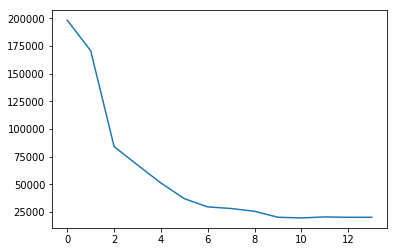

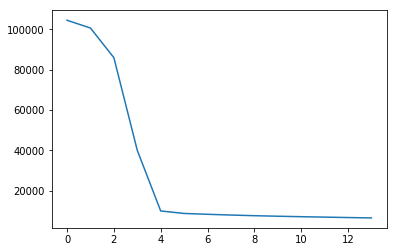

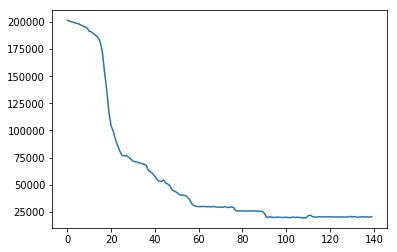

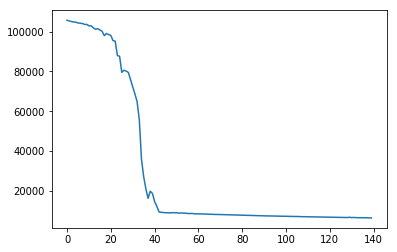

epoch 15 start
heatmap cost
Heat_loss :  16930.998
vectormap cost
Vector_loss :  6433.503


avg'Heat_loss :  19780.618359375
avg'Vector_loss :  6130.20576171875


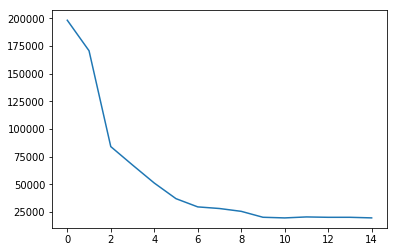

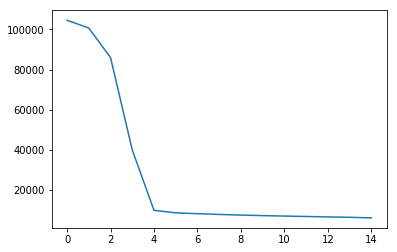

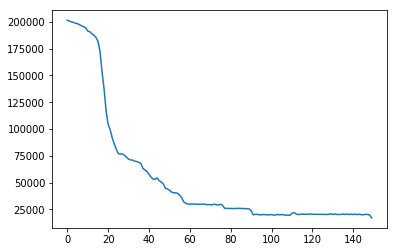

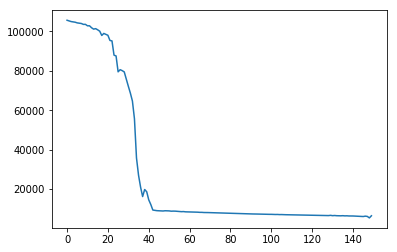

epoch 16 start
heatmap cost
Heat_loss :  11243.618
vectormap cost
Vector_loss :  1723.2307


avg'Heat_loss :  11299.1978515625
avg'Vector_loss :  2058.3866333007813


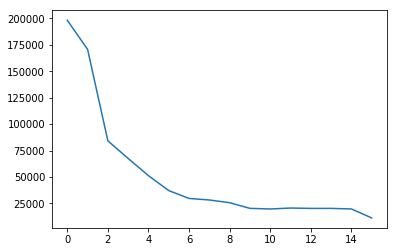

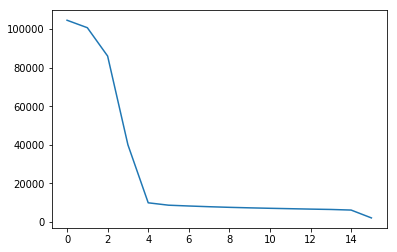

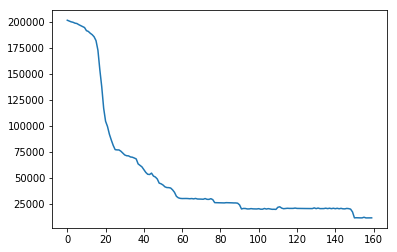

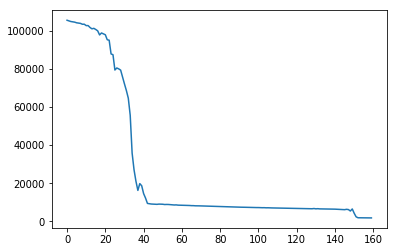

epoch 17 start
heatmap cost
Heat_loss :  11211.857
vectormap cost
Vector_loss :  1596.2429


avg'Heat_loss :  11192.60478515625
avg'Vector_loss :  1648.6804565429688


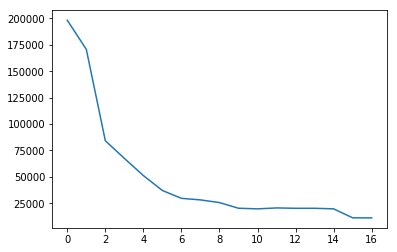

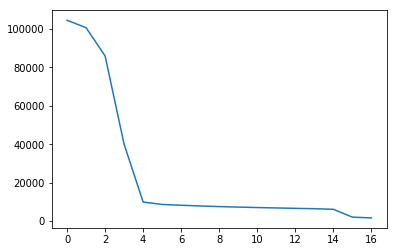

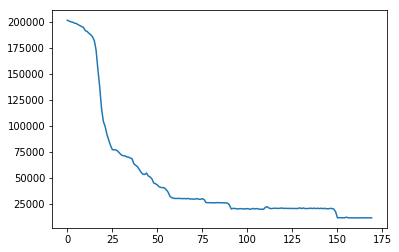

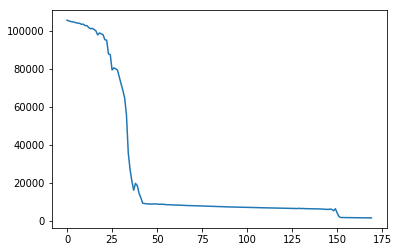

epoch 18 start
heatmap cost
Heat_loss :  6663.783
vectormap cost
Vector_loss :  1490.4929


avg'Heat_loss :  7489.64658203125
avg'Vector_loss :  1537.0743530273437


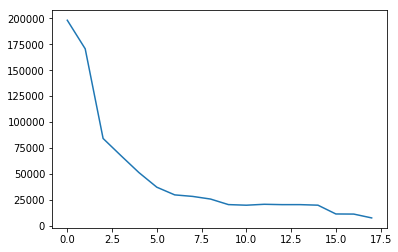

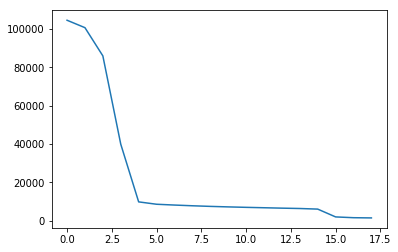

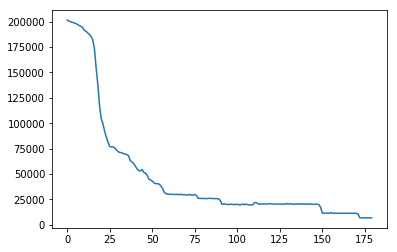

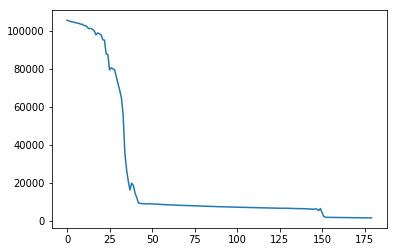

epoch 19 start
heatmap cost
Heat_loss :  6584.6074
vectormap cost
Vector_loss :  1395.5994


avg'Heat_loss :  6597.34423828125
avg'Vector_loss :  1437.344140625


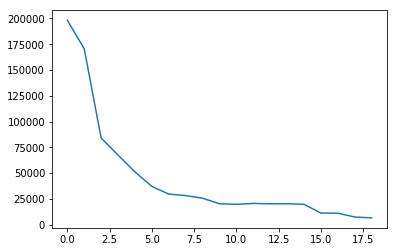

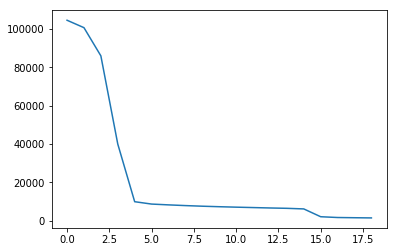

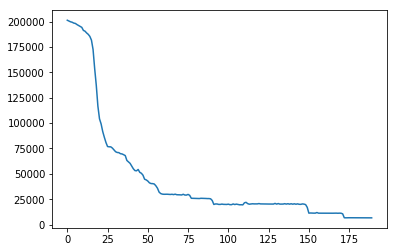

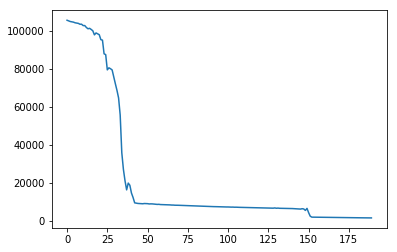

epoch 20 start
heatmap cost
Heat_loss :  6556.192
vectormap cost
Vector_loss :  1310.9039


avg'Heat_loss :  6535.288818359375
avg'Vector_loss :  1348.090087890625


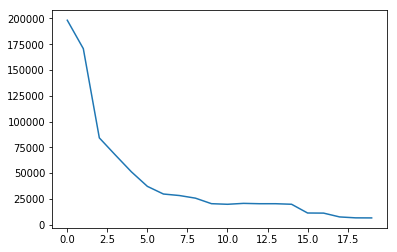

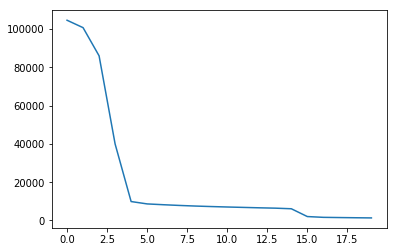

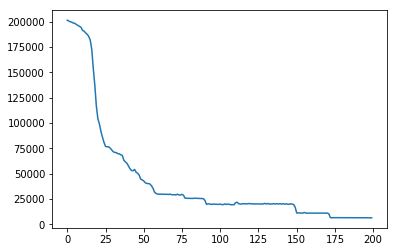

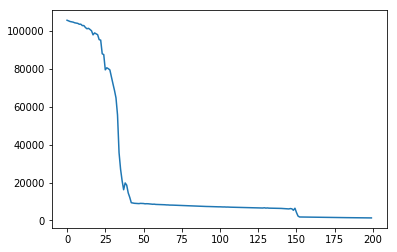

epoch 21 start
heatmap cost
Heat_loss :  6449.2754
vectormap cost
Vector_loss :  1235.5458


avg'Heat_loss :  6456.881640625
avg'Vector_loss :  1268.5572509765625


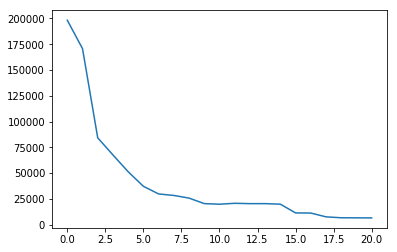

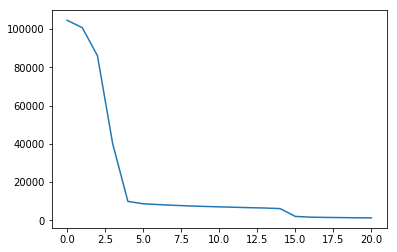

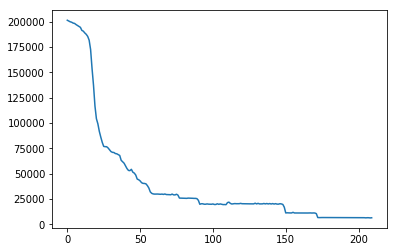

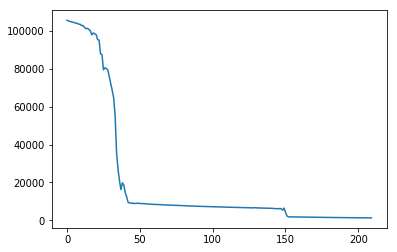

epoch 22 start
heatmap cost
Heat_loss :  6736.336
vectormap cost
Vector_loss :  1168.7141


avg'Heat_loss :  6629.1994140625
avg'Vector_loss :  1197.924560546875


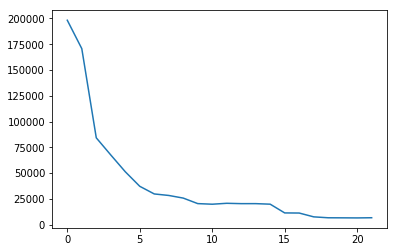

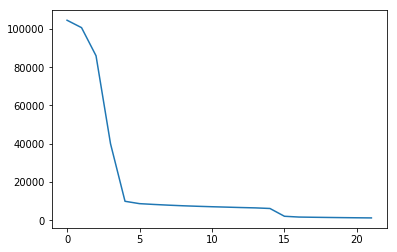

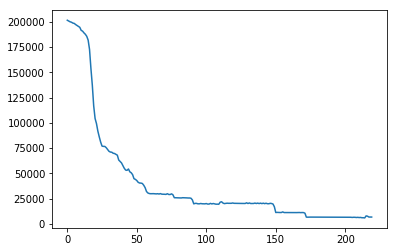

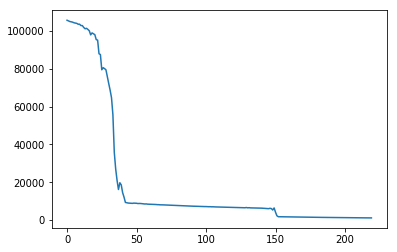

epoch 23 start
heatmap cost
Heat_loss :  6854.6255
vectormap cost
Vector_loss :  1109.6317


avg'Heat_loss :  6843.842236328125
avg'Vector_loss :  1135.3366088867188


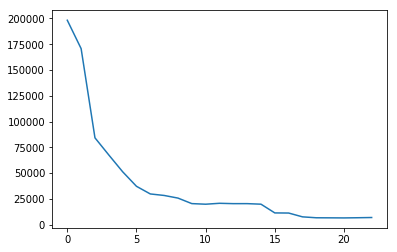

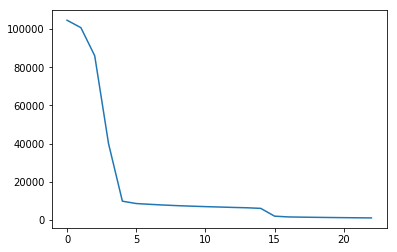

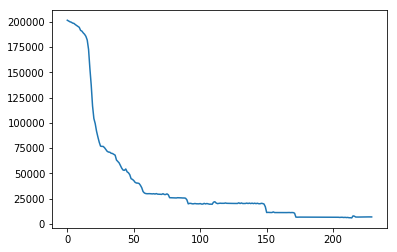

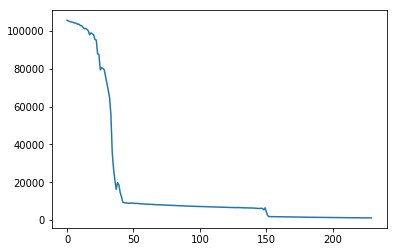

epoch 24 start
heatmap cost
Heat_loss :  6806.431
vectormap cost
Vector_loss :  1057.5884


avg'Heat_loss :  6849.000146484375
avg'Vector_loss :  1080.2261962890625


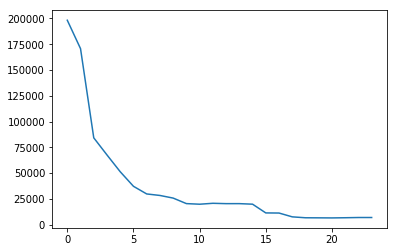

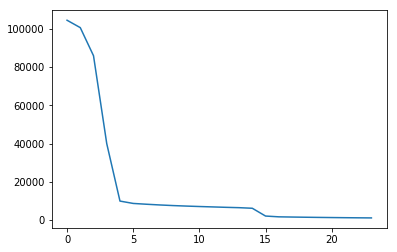

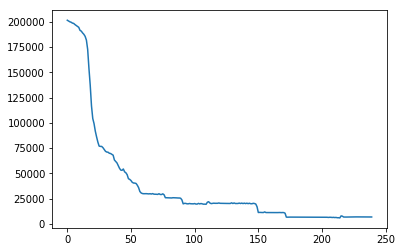

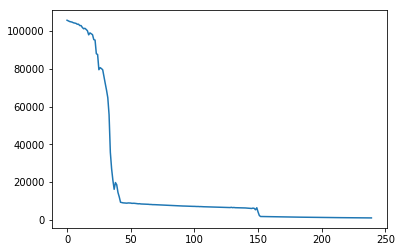

epoch 25 start
heatmap cost
Heat_loss :  6731.089
vectormap cost
Vector_loss :  1011.2321


avg'Heat_loss :  6767.165966796875
avg'Vector_loss :  1031.6465637207032


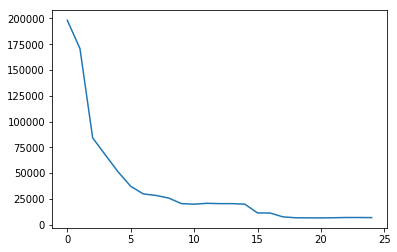

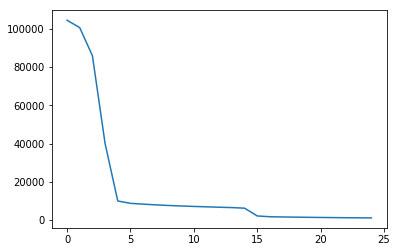

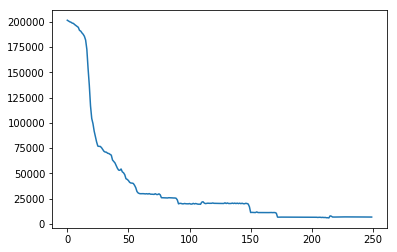

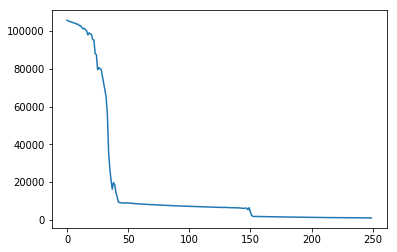

epoch 26 start
heatmap cost
Heat_loss :  6687.452
vectormap cost
Vector_loss :  971.9797


avg'Heat_loss :  6696.31298828125
avg'Vector_loss :  989.2105224609375


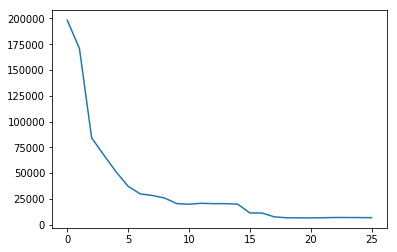

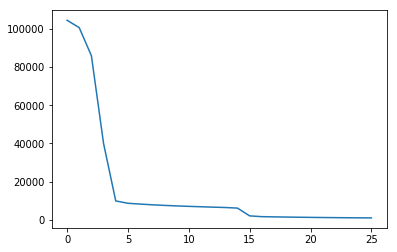

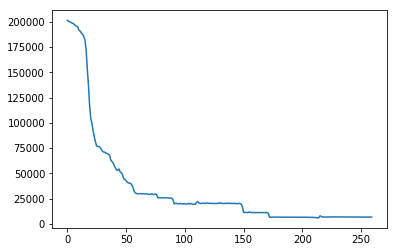

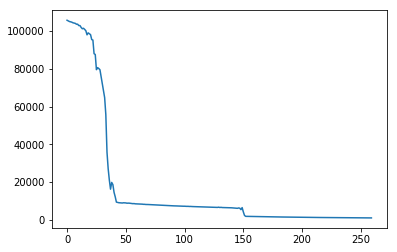

epoch 27 start
heatmap cost
Heat_loss :  6658.8296
vectormap cost
Vector_loss :  937.12006


avg'Heat_loss :  6654.02412109375
avg'Vector_loss :  952.0946899414063


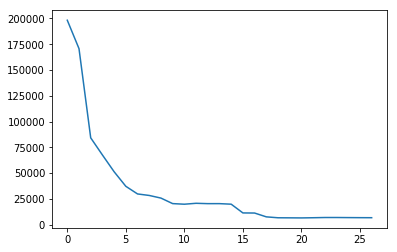

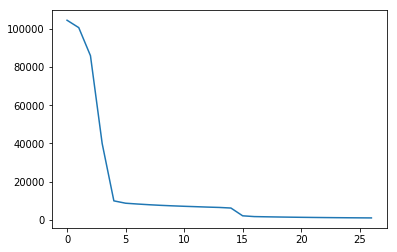

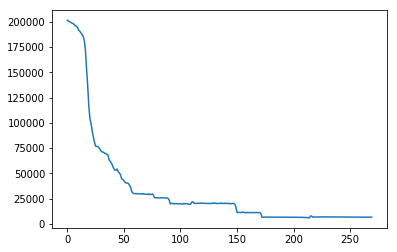

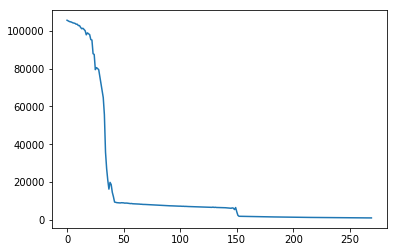

epoch 28 start
heatmap cost
Heat_loss :  6566.2017
vectormap cost
Vector_loss :  906.01733


avg'Heat_loss :  6595.7103515625
avg'Vector_loss :  919.4597595214843


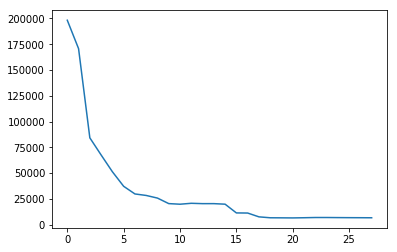

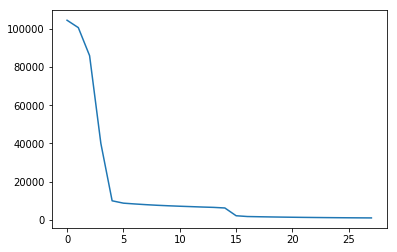

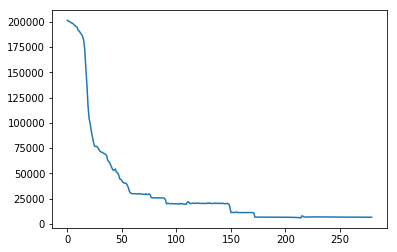

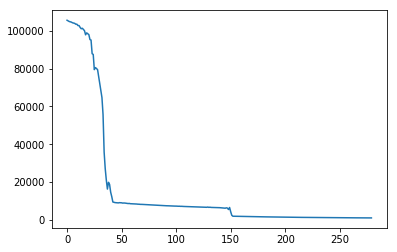

epoch 29 start
heatmap cost
Heat_loss :  6541.65
vectormap cost
Vector_loss :  879.75476


avg'Heat_loss :  6583.728955078125
avg'Vector_loss :  891.6028137207031


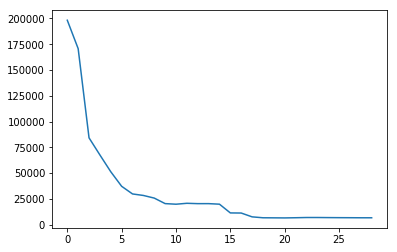

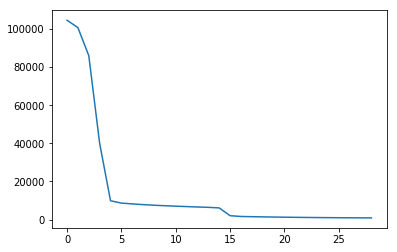

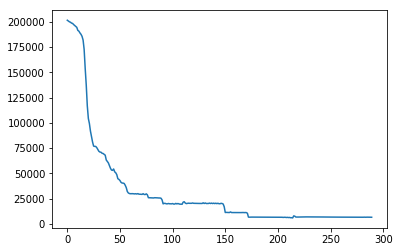

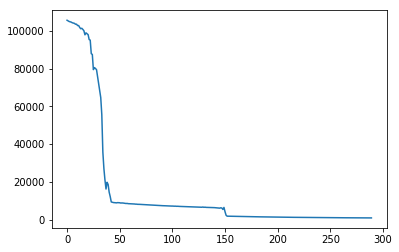

epoch 30 start
heatmap cost
Heat_loss :  6522.334
vectormap cost
Vector_loss :  857.13135


avg'Heat_loss :  6573.015087890625
avg'Vector_loss :  867.4954345703125


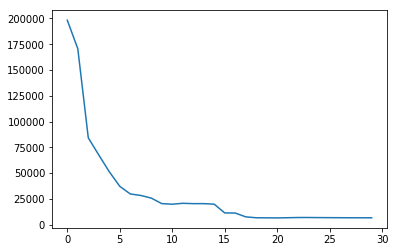

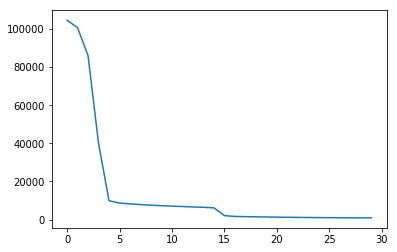

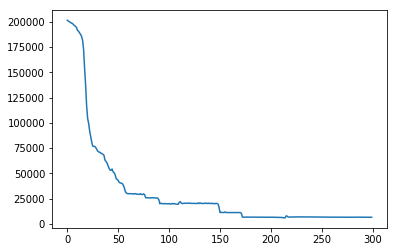

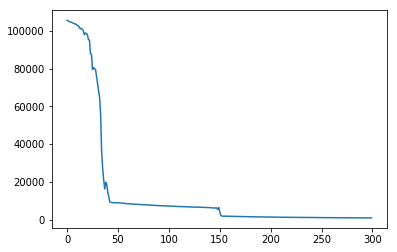

epoch 31 start
heatmap cost
Heat_loss :  6503.7227
vectormap cost
Vector_loss :  837.68463


avg'Heat_loss :  6540.232421875
avg'Vector_loss :  846.4657531738281


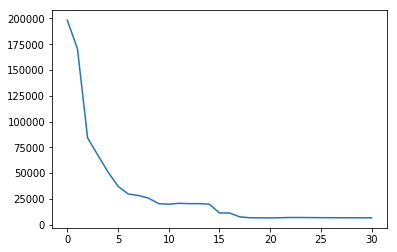

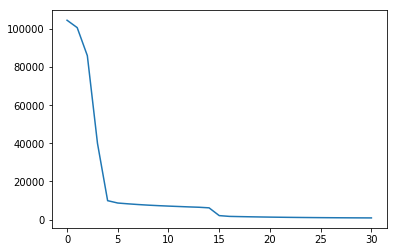

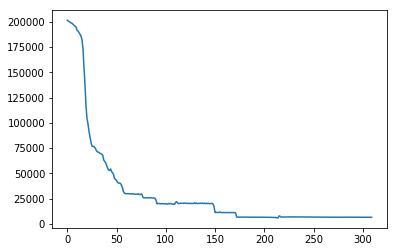

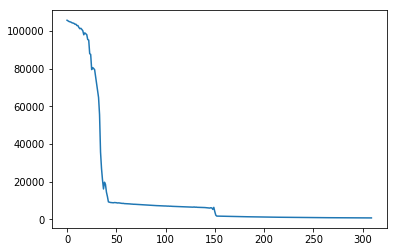

epoch 32 start
heatmap cost
Heat_loss :  6493.2534
vectormap cost
Vector_loss :  820.9987


avg'Heat_loss :  6550.344140625
avg'Vector_loss :  828.7773132324219


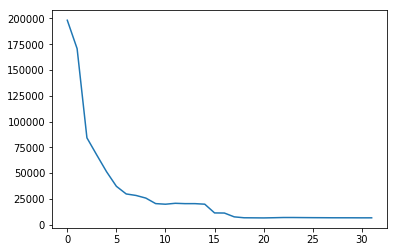

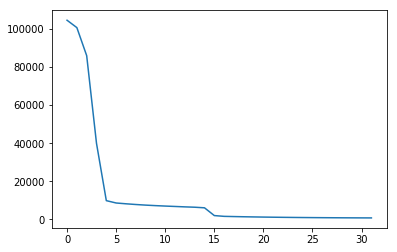

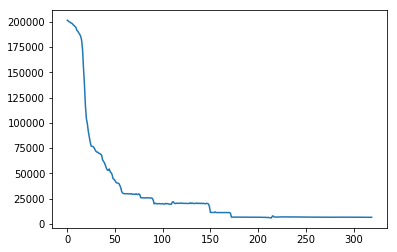

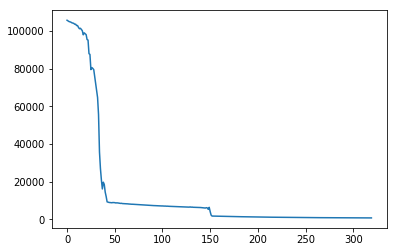

epoch 33 start
heatmap cost
Heat_loss :  6589.2593
vectormap cost
Vector_loss :  807.80914


avg'Heat_loss :  6561.668603515625
avg'Vector_loss :  813.7064819335938


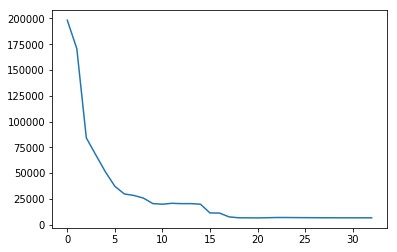

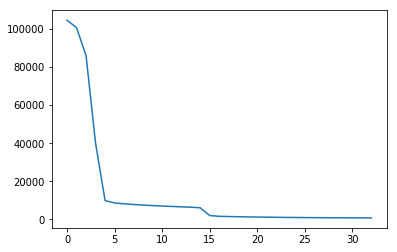

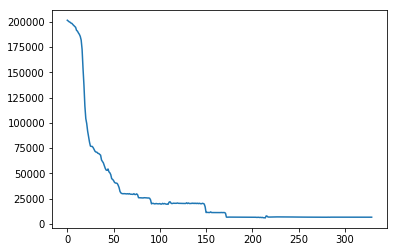

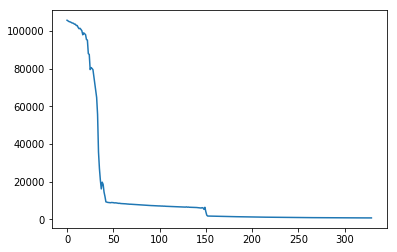

epoch 34 start
heatmap cost
Heat_loss :  6477.283
vectormap cost
Vector_loss :  794.6993


avg'Heat_loss :  6535.18134765625
avg'Vector_loss :  800.4943420410157


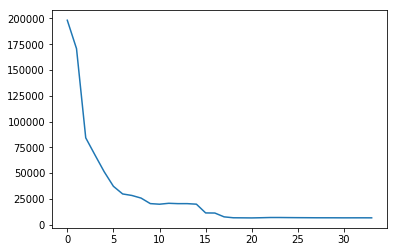

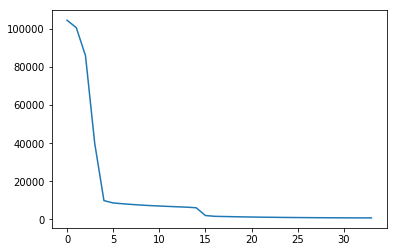

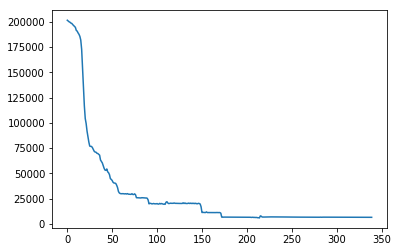

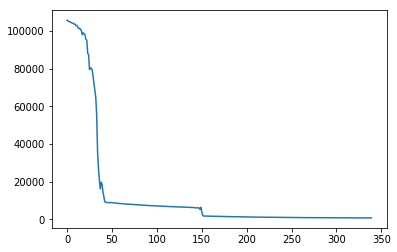

epoch 35 start
heatmap cost
Heat_loss :  6467.7617
vectormap cost
Vector_loss :  784.4595


avg'Heat_loss :  6517.844189453125
avg'Vector_loss :  789.3542846679687


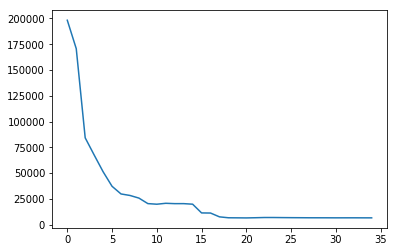

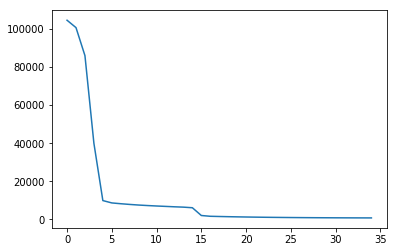

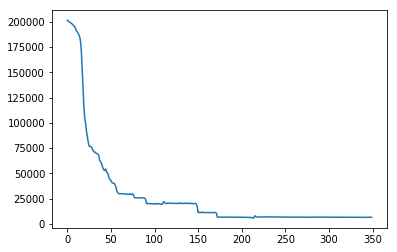

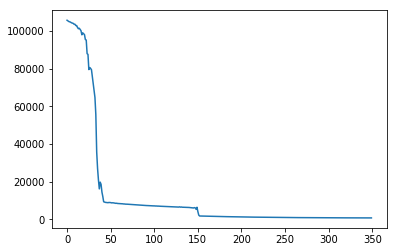

epoch 36 start
heatmap cost
Heat_loss :  6463.4707
vectormap cost
Vector_loss :  775.81964


avg'Heat_loss :  6525.304736328125
avg'Vector_loss :  780.1316589355469


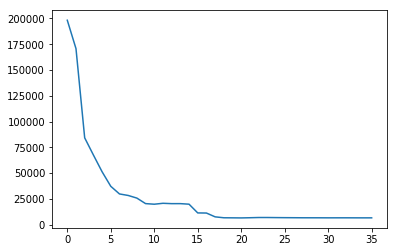

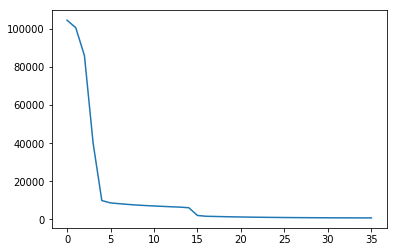

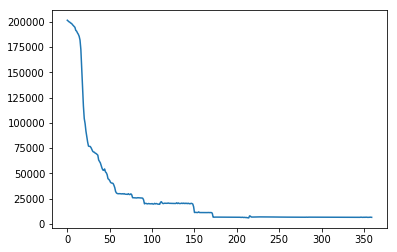

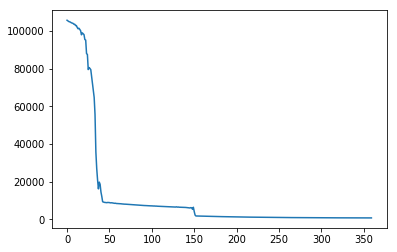

epoch 37 start
heatmap cost
Heat_loss :  6468.0537
vectormap cost
Vector_loss :  768.5781


avg'Heat_loss :  6558.174365234375
avg'Vector_loss :  772.6012756347657


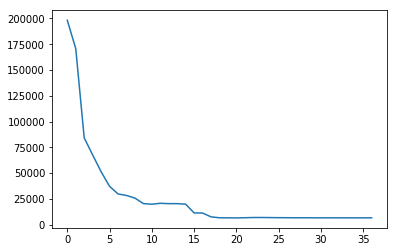

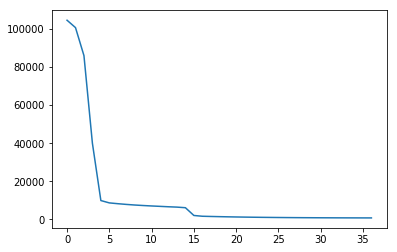

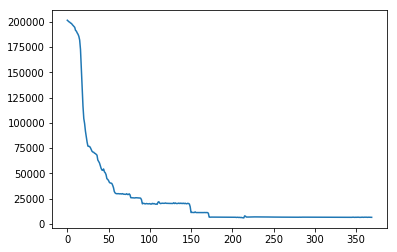

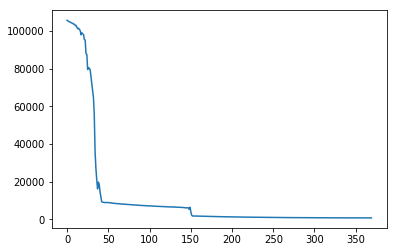

epoch 38 start
heatmap cost
Heat_loss :  6586.0117
vectormap cost
Vector_loss :  763.60266


avg'Heat_loss :  6510.188623046875
avg'Vector_loss :  765.5768127441406


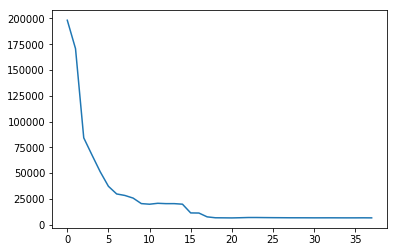

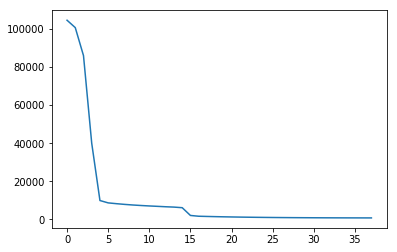

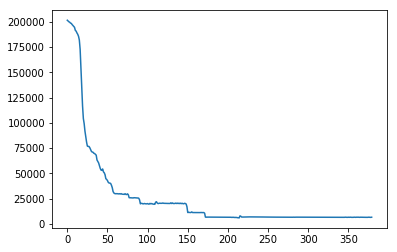

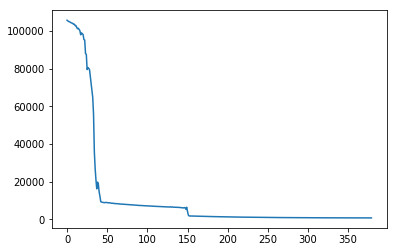

epoch 39 start
heatmap cost
Heat_loss :  6578.309
vectormap cost
Vector_loss :  758.5363


avg'Heat_loss :  6544.239892578125
avg'Vector_loss :  760.3961975097657


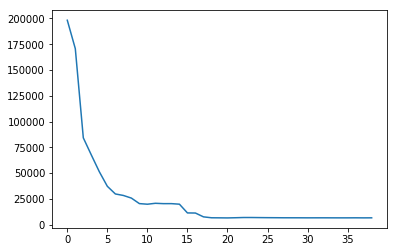

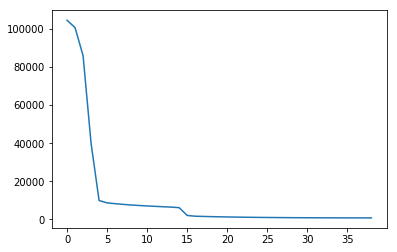

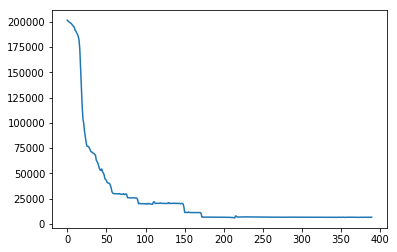

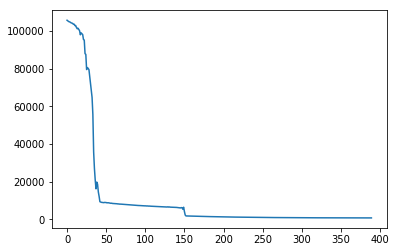

epoch 40 start
heatmap cost
Heat_loss :  6447.3154
vectormap cost
Vector_loss :  753.15344


avg'Heat_loss :  6478.703076171875
avg'Vector_loss :  755.2256958007813


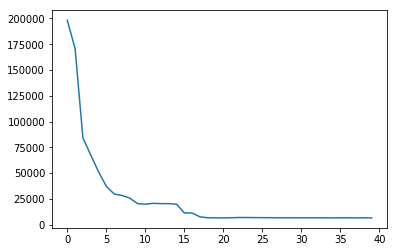

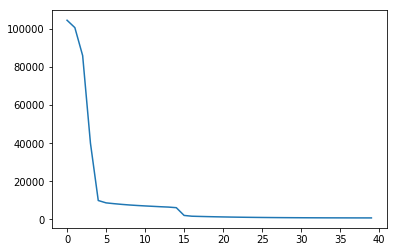

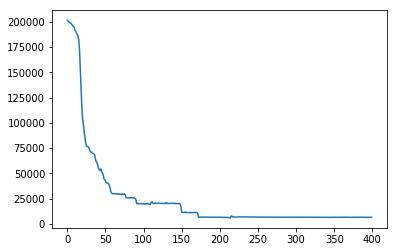

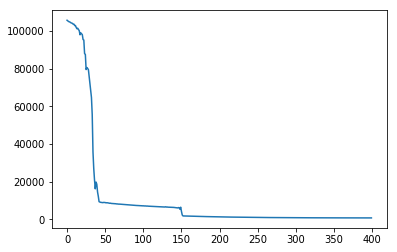

epoch 41 start
heatmap cost
Heat_loss :  6581.872
vectormap cost
Vector_loss :  750.8534


avg'Heat_loss :  6515.516552734375
avg'Vector_loss :  751.7573425292969


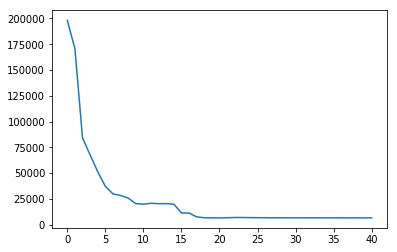

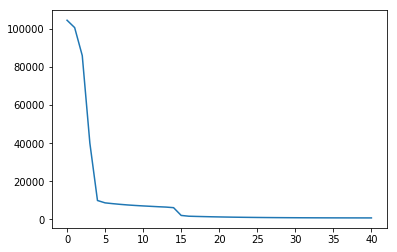

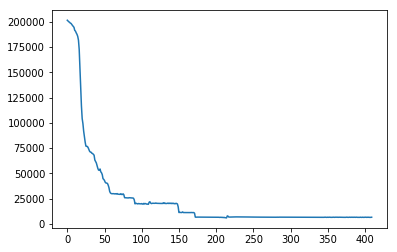

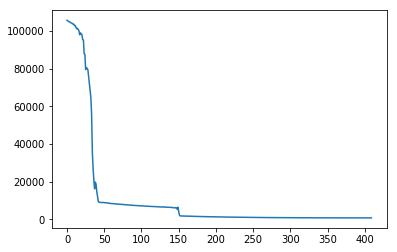

epoch 42 start
heatmap cost
Heat_loss :  6583.159
vectormap cost
Vector_loss :  747.955


avg'Heat_loss :  6513.913427734375
avg'Vector_loss :  748.6050231933593


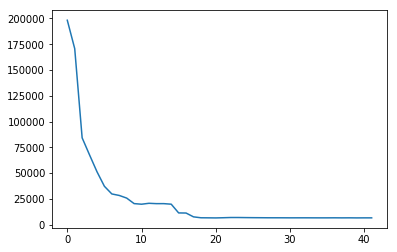

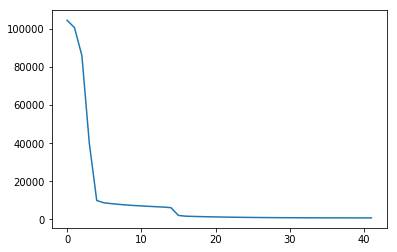

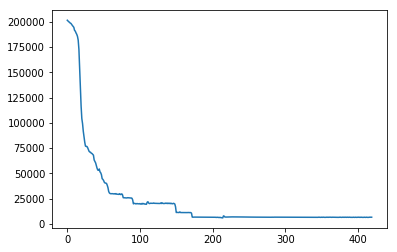

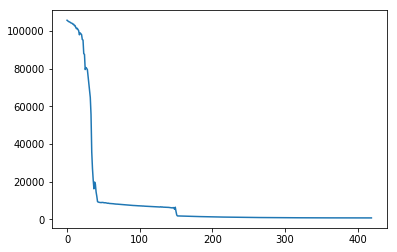

epoch 43 start
heatmap cost
Heat_loss :  6577.195
vectormap cost
Vector_loss :  745.5833


avg'Heat_loss :  6526.921337890625
avg'Vector_loss :  746.136376953125


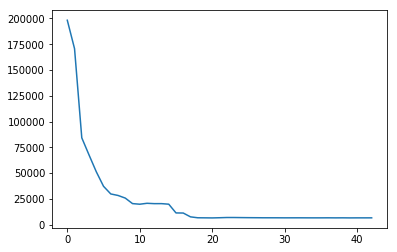

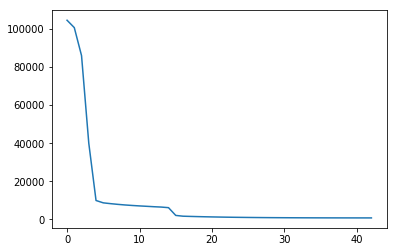

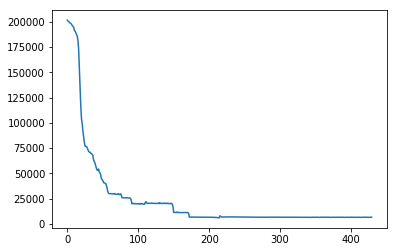

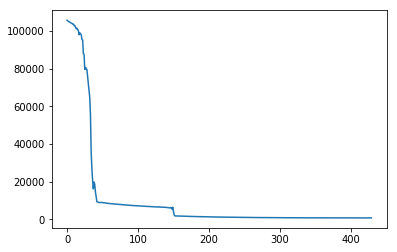

epoch 44 start
heatmap cost
Heat_loss :  6575.046
vectormap cost
Vector_loss :  743.64404


avg'Heat_loss :  6537.63125
avg'Vector_loss :  744.1254943847656


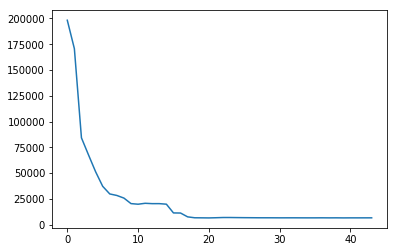

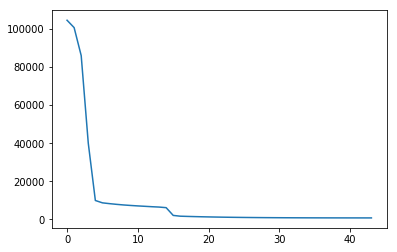

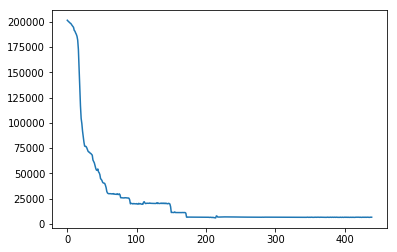

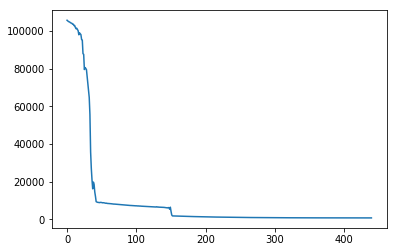

epoch 45 start
heatmap cost
Heat_loss :  6440.8525
vectormap cost
Vector_loss :  740.81604


avg'Heat_loss :  6483.646240234375
avg'Vector_loss :  741.8886840820312


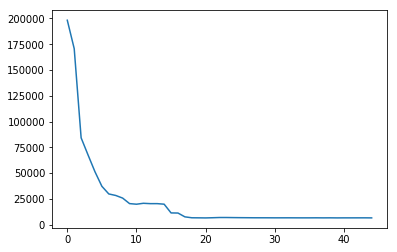

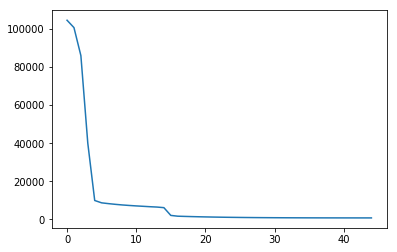

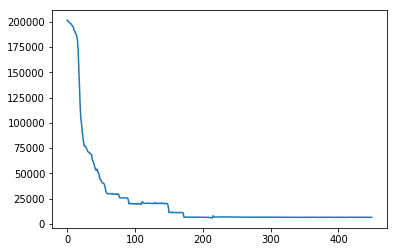

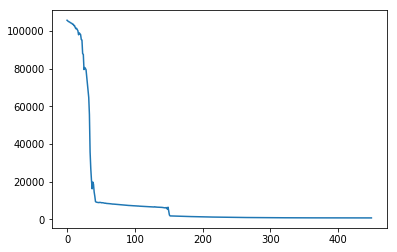

epoch 46 start
heatmap cost
Heat_loss :  6438.4233
vectormap cost
Vector_loss :  739.5188


avg'Heat_loss :  6495.585302734375
avg'Vector_loss :  740.5870178222656


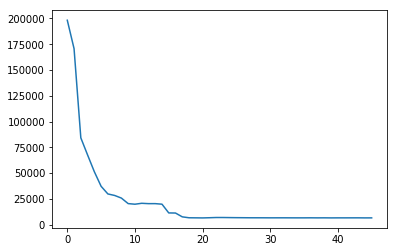

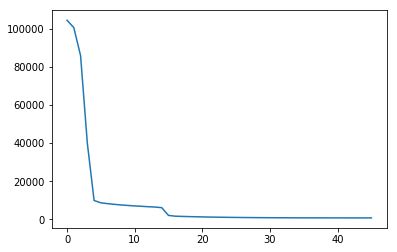

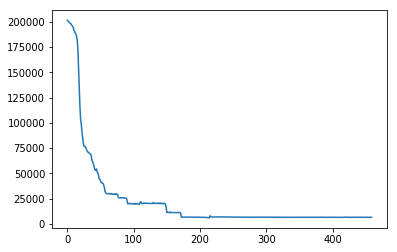

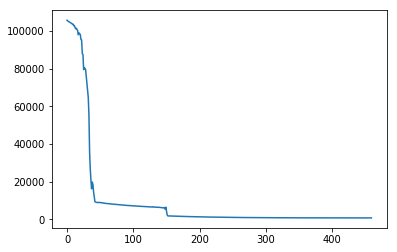

epoch 47 start
heatmap cost
Heat_loss :  6445.186
vectormap cost
Vector_loss :  738.4696


avg'Heat_loss :  6536.517236328125
avg'Vector_loss :  739.8040649414063


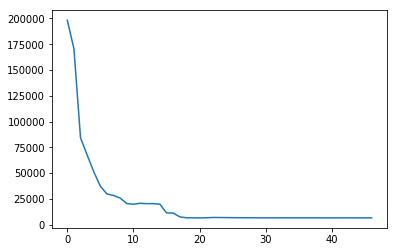

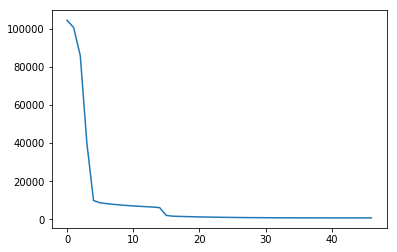

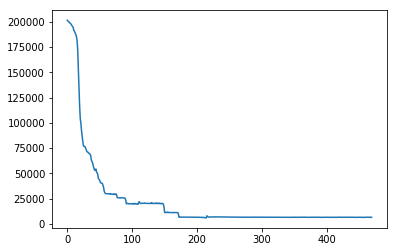

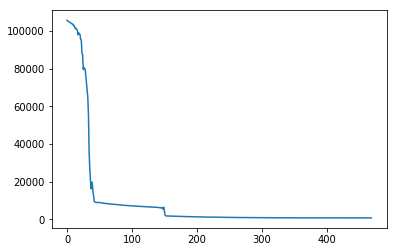

epoch 48 start
heatmap cost
Heat_loss :  6576.128
vectormap cost
Vector_loss :  738.89026


avg'Heat_loss :  6508.115283203125
avg'Vector_loss :  738.6269714355469


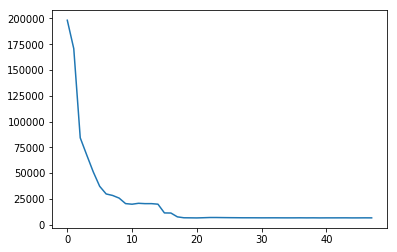

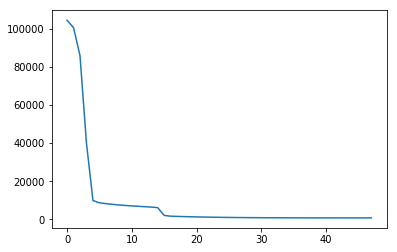

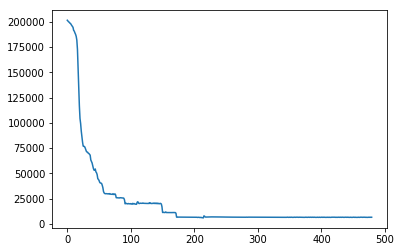

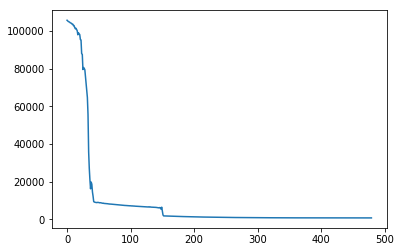

epoch 49 start
heatmap cost
Heat_loss :  6435.616
vectormap cost
Vector_loss :  736.93744


avg'Heat_loss :  6491.14248046875
avg'Vector_loss :  737.7603210449219


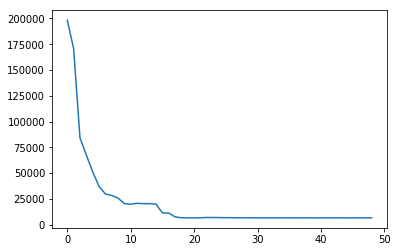

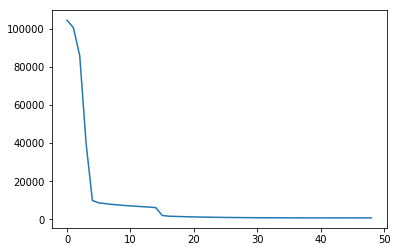

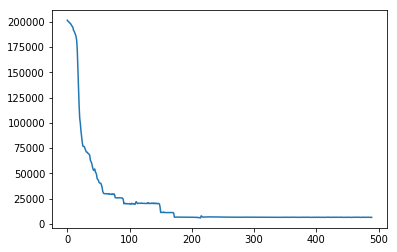

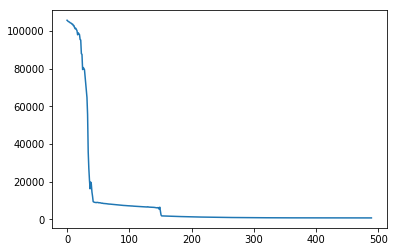

epoch 50 start
heatmap cost
Heat_loss :  6569.501
vectormap cost
Vector_loss :  737.6848


avg'Heat_loss :  6516.2203125
avg'Vector_loss :  737.40361328125


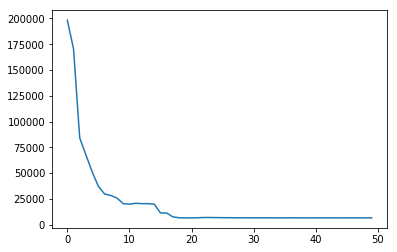

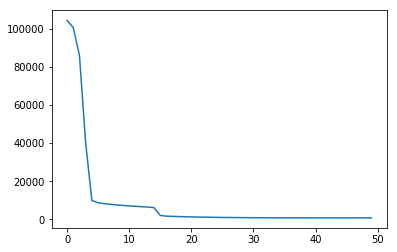

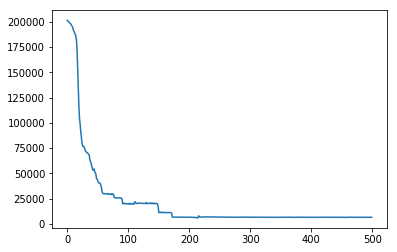

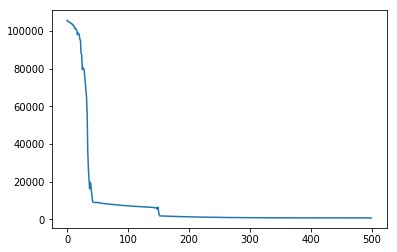

epoch 51 start
heatmap cost
Heat_loss :  6431.125
vectormap cost
Vector_loss :  735.96063


avg'Heat_loss :  6487.06708984375
avg'Vector_loss :  736.6759033203125


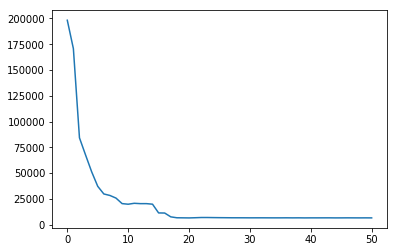

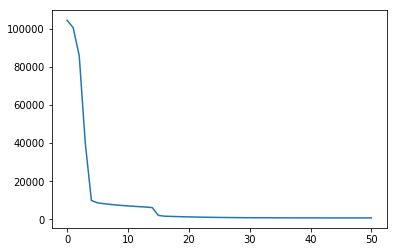

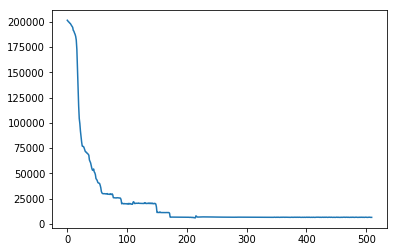

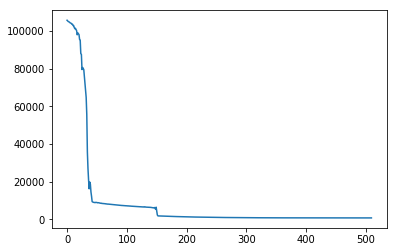

epoch 52 start
heatmap cost
Heat_loss :  6431.284
vectormap cost
Vector_loss :  735.5918


avg'Heat_loss :  6498.814453125
avg'Vector_loss :  736.4092041015625


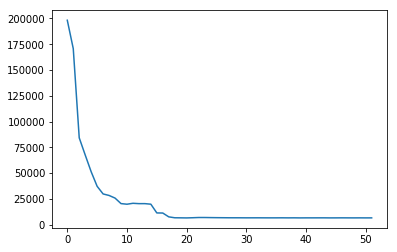

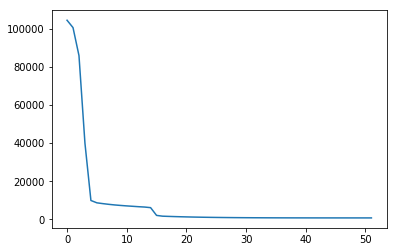

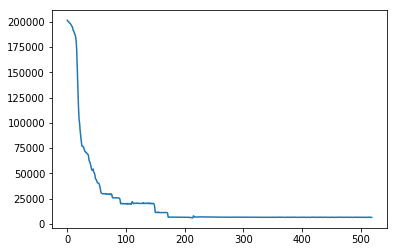

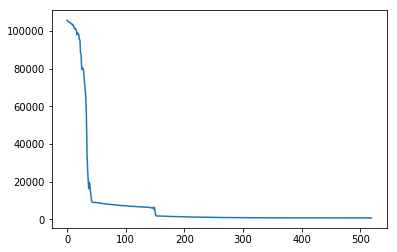

epoch 53 start
heatmap cost
Heat_loss :  6420.365
vectormap cost
Vector_loss :  735.31995


avg'Heat_loss :  6480.27333984375
avg'Vector_loss :  735.9826965332031


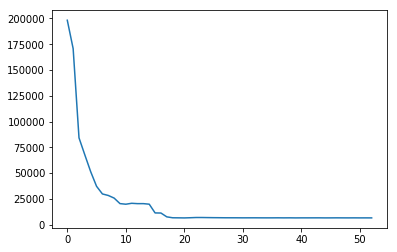

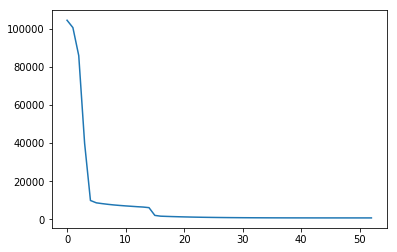

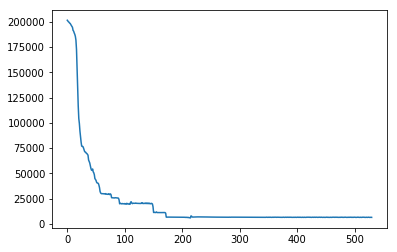

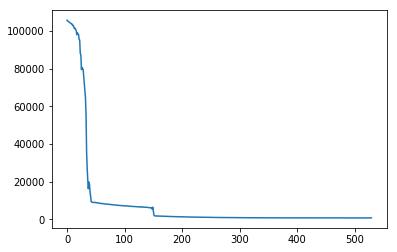

epoch 54 start
heatmap cost
Heat_loss :  6562.365
vectormap cost
Vector_loss :  736.44116


avg'Heat_loss :  6476.01279296875
avg'Vector_loss :  735.734423828125


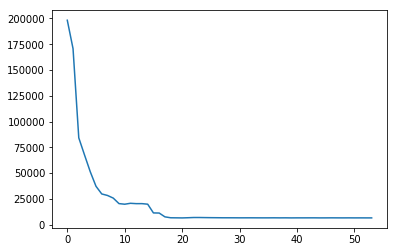

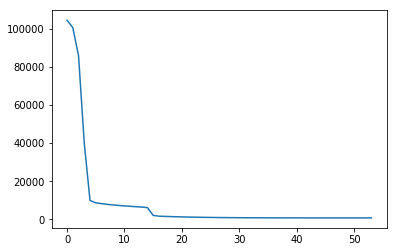

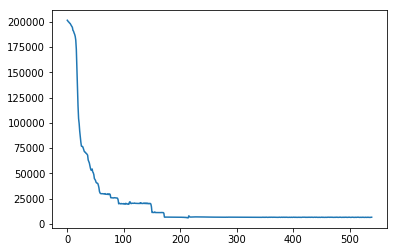

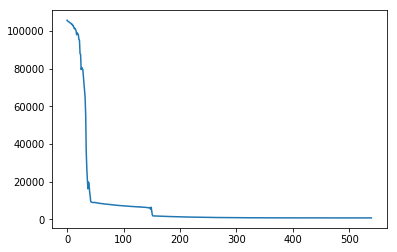

epoch 55 start
heatmap cost
Heat_loss :  6418.716
vectormap cost
Vector_loss :  734.94214


avg'Heat_loss :  6497.22216796875
avg'Vector_loss :  735.8027954101562


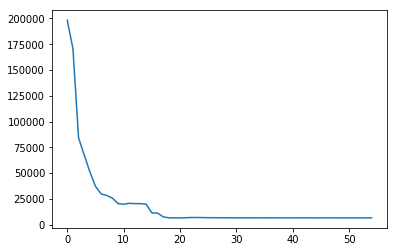

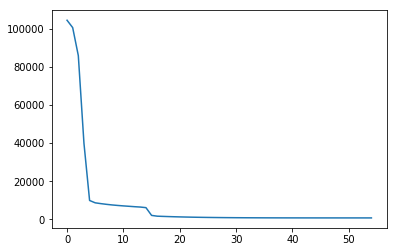

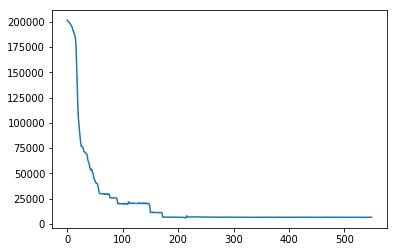

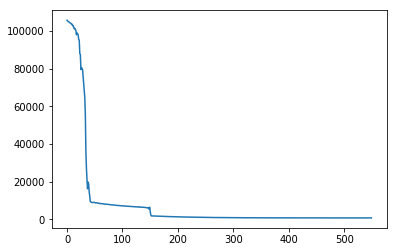

epoch 56 start
heatmap cost
Heat_loss :  6538.929
vectormap cost
Vector_loss :  736.10474


avg'Heat_loss :  6444.437353515625
avg'Vector_loss :  735.2464782714844


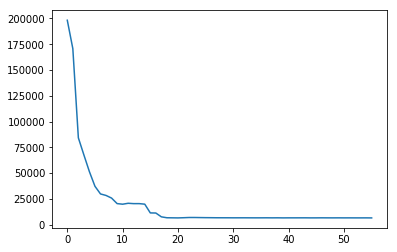

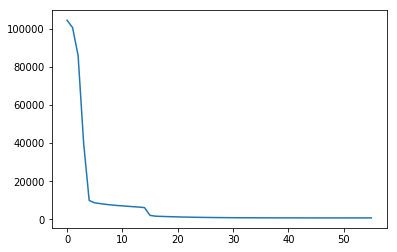

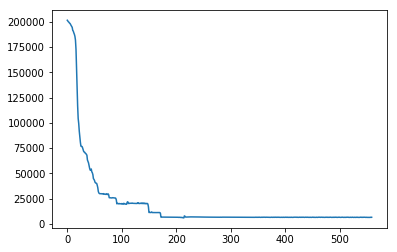

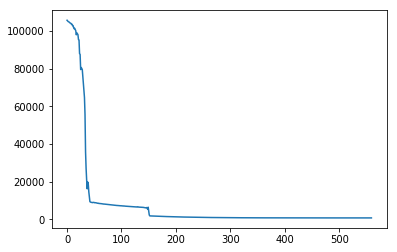

epoch 57 start
heatmap cost
Heat_loss :  6478.5464
vectormap cost
Vector_loss :  736.00635


avg'Heat_loss :  6471.890576171875
avg'Vector_loss :  735.6493957519531


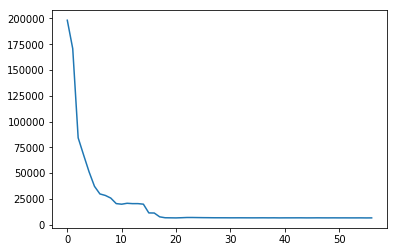

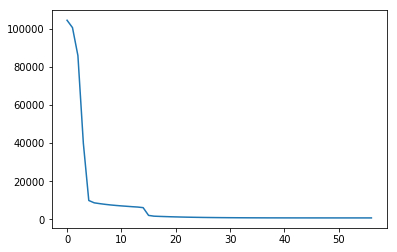

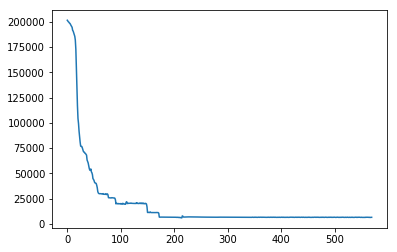

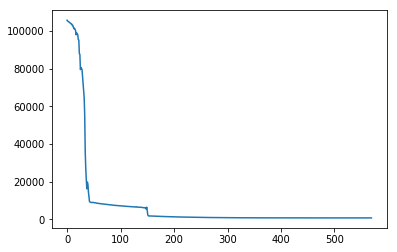

epoch 58 start
heatmap cost
Heat_loss :  7620.4414
vectormap cost
Vector_loss :  734.6142


avg'Heat_loss :  6379.681884765625
avg'Vector_loss :  735.5674133300781


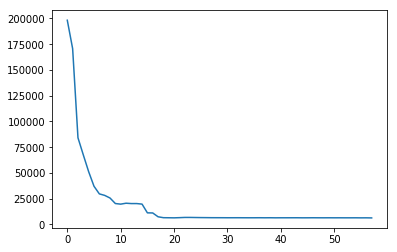

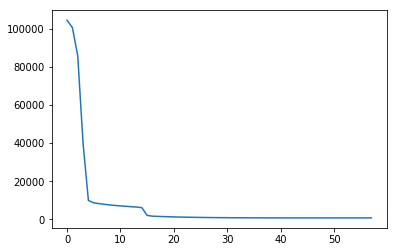

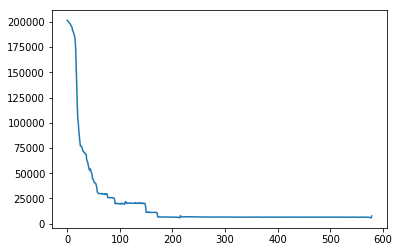

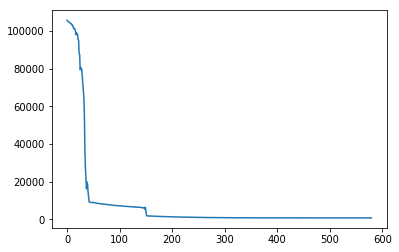

epoch 59 start
heatmap cost
Heat_loss :  8190.9443
vectormap cost
Vector_loss :  735.85266


avg'Heat_loss :  8124.90263671875
avg'Vector_loss :  735.4942565917969


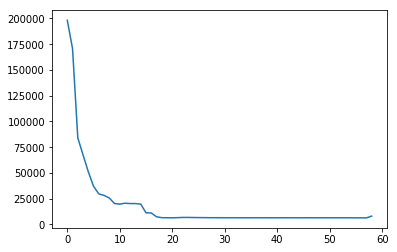

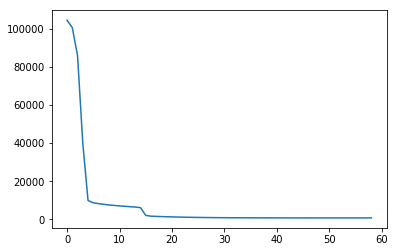

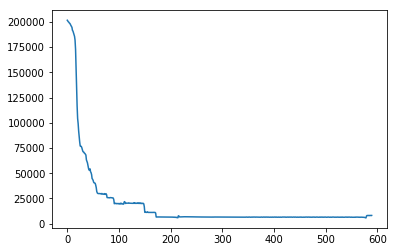

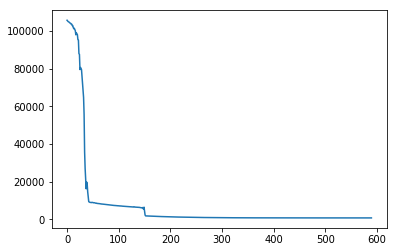

epoch 60 start


KeyboardInterrupt: 

In [4]:
with tf.Session() as sess:
    obj = openpose(batch_size=1, sess = sess)
    obj.train()

In [ ]:
heatloss = np.load("./Loss/heat_loss.npz")
vectorloss = np.load("./Loss/vector_loss.npz")

In [ ]:
heatloss.files

In [ ]:
heatloss['arr_1']

In [ ]:
vectorloss.files

In [ ]:
vectorloss['arr_1']

data test session

In [4]:
#input, label data가 잘 들어가는가 test 해봄.
with tf.Session() as sess:
    obj = openpose(batch_size=1, sess = sess)
    _batch_video_data, transpose_heatmap, transpose_vectormap, transpose_countmap, _transposed_batch_anno_data= obj.data_test()

__batch_video_data = np.squeeze(_batch_video_data)
print(np.shape(_batch_video_data))
print(np.shape(__batch_video_data))
#for i in range(60):
#    plt.imshow(__batch_video_data[i])
#    plt.show()

test data load start
test data load finish
vgg_19_3d_output :  (?, 60, 14, 14, 32)
RNN output's shape :  (1, 60, 6272)
RNN reshaped output's shape :  (1, 60, 14, 14, 32)
block_3d_stage_1_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_1_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_2_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_2_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_3_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_3_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_4_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_4_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_5_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_5_branch2 :  (1, 60, 14, 14, 17)
block_3d_stage_6_branch1 :  (1, 60, 14, 14, 34)
block_3d_stage_6_branch2 :  (1, 60, 14, 14, 17)
open pose init complete
epoch 1 start
test video :  ['./video_with_abstacle/TrainingSet_2/1/108.avi']
sol1 :  (60, 1, 17, 14, 14)
sol2 :  (60, 1, 14, 14, 34)
(1, 60, 112, 112, 3)
(60, 112, 112, 3)


In [6]:
np.shape(__batch_video_data)
np.shape(_batch_video_data)

(1, 60, 112, 112, 3)

In [ ]:
_transpose_heatmap = np.squeeze(transpose_heatmap)
_transpose_vectormap = np.squeeze(transpose_vectormap)
print("_transpose_heatmap's shape : ", np.shape(_transpose_heatmap))
print("_transpose_vectormap's shape : ", np.shape(_transpose_vectormap))
__transpose_heatmap = np.transpose(_transpose_heatmap, (0, 3, 1, 2))
__transpose_vectormap = np.transpose(_transpose_vectormap, (0, 3, 2, 1))
print("__transpose_heatmap's shape : ", np.shape(__transpose_heatmap))
print("__transpose_vectormap's shape : ", np.shape(__transpose_vectormap))

In [ ]:
buffer = np.zeros((network_output_width, network_output_width))
print(np.shape(__transpose_heatmap))#60 17 14 14
for j in range(16):
    buffer = buffer + __transpose_heatmap[0][j]
    plt.imshow(__transpose_heatmap[0][j])
    plt.show()
plt.imshow(buffer)
plt.show()
#plt.imshow(__transpose_heatmap[0][0]+__transpose_heatmap[0][1]+__transpose_heatmap[0][2]+\
#          __transpose_heatmap[0][3]+__transpose_heatmap[0][4]+__transpose_heatmap[0][5]+\
#          __transpose_heatmap[0][6]+__transpose_heatmap[0][7]+__transpose_heatmap[0][8]+\
#          __transpose_heatmap[0][9]+__transpose_heatmap[0][10]+__transpose_heatmap[0][11]+\
#          __transpose_heatmap[0][12]+__transpose_heatmap[0][13]+__transpose_heatmap[0][14]+\
#          __transpose_heatmap[0][15]+__transpose_heatmap[0][16]+__transpose_heatmap[0][0]+\)

In [ ]:
print("---------------heatmap------------------------")
for i in range(60):
    buffer = np.zeros((network_output_width, network_output_width))
    for j in range(16):
        buffer = buffer + __transpose_heatmap[i][j]
        #if(buffer.min() < 0.0):
        #    print(i)
    plt.imshow(buffer, cmap="bone")
    plt.show()
print("---------------vectormap------------------------")
for i in range(60):
    buffer = np.zeros((network_output_width, network_output_width))
    for j in range(32):
        buffer = buffer + __transpose_vectormap[i][j]
    plt.imshow(buffer,cmap="bone")
    plt.show()
_transposed_batch_anno_data

In [ ]:
__transpose_heatmap.min()

In [ ]:
#heatmap, vectormap에 들어가는 데이터들이 0~1 사이 값들을 갖는지 확인하려고 넣은 부분. 삭제해도 무방.
np.shape(__transpose_vectormap)
for i in range(60):
    for j in range(34):
        for row in range(14):
            for col in range(14):
                if(__transpose_vectormap[i][j][row][col] != 0.0):
                    print(__transpose_vectormap[i][j][row][col])

In [ ]:
np.shape(_batch_video_data)
a = _batch_video_data

In [ ]:
data = np.zeros((1, 60, 112, 112, 3), dtype=np.float32)
for i in range(1):
    for j in range(60):
        for row in range(112):
            for col in range(112):
                for channel in range(3):
                    data[i][j][row][col][channel] = _batch_video_data[i][j][row][col][channel] / 255

In [ ]:
_batch_video_data

output test session

In [4]:
#output test
with tf.Session() as sess:
    obj = openpose(batch_size=1, sess = sess)
    vectormap, heatmap, vgg = obj.test()

test data load start
test data load finish
RNN output's shape :  (1, 60, 6272)
RNN reshaped output's shape :  (60, 14, 14, 32)
open pose init complete
test video :  ['./video_with_abstacle/TrainingSet_2/1/118.avi']
graph init start
graph init finish
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_rnn/Weight.ckpt
----------------Weight load----------------


In [5]:
np.shape(vectormap)

(60, 14, 14, 34)

_transpose_heatmap's shape :  (60, 14, 14, 17)
_transpose_vectormap's shape :  (60, 14, 14, 34)
__transpose_heatmap's shape :  (60, 17, 14, 14)
__transpose_vectormap's shape :  (60, 34, 14, 14)
(60, 17, 14, 14)


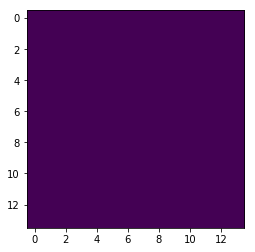

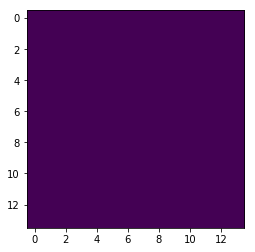

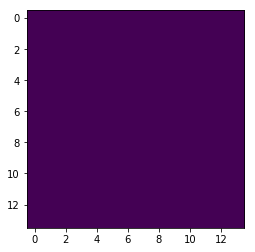

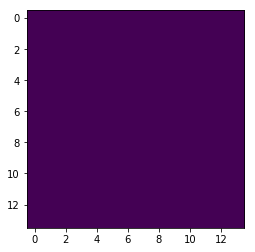

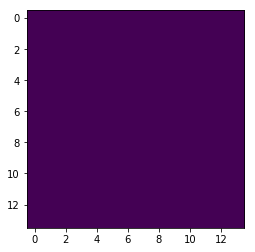

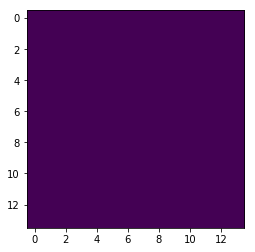

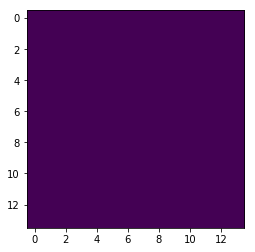

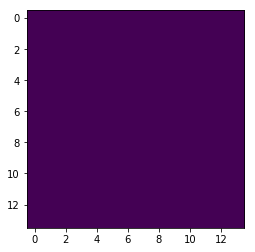

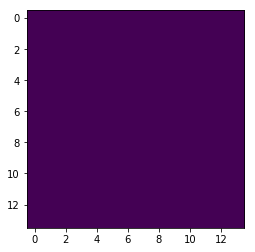

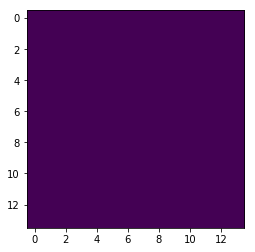

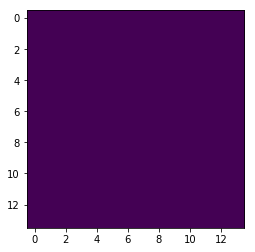

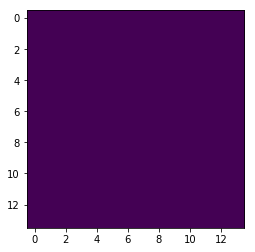

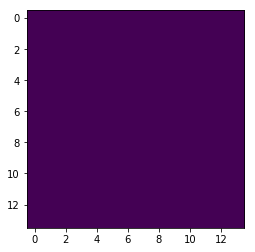

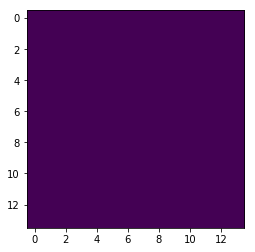

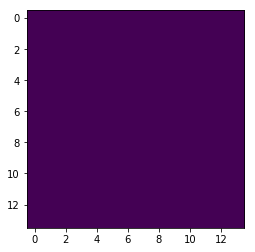

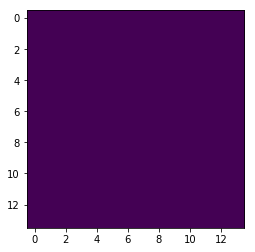

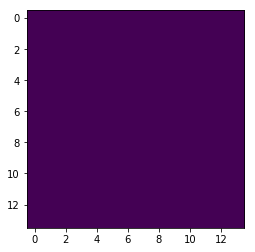

In [6]:
_transpose_heatmap = np.squeeze(heatmap)
_transpose_vectormap = np.squeeze(vectormap)
print("_transpose_heatmap's shape : ", np.shape(_transpose_heatmap))
print("_transpose_vectormap's shape : ", np.shape(_transpose_vectormap))
__transpose_heatmap = np.transpose(_transpose_heatmap, (0, 3, 1, 2))
__transpose_vectormap = np.transpose(_transpose_vectormap, (0, 3, 2, 1))
print("__transpose_heatmap's shape : ", np.shape(__transpose_heatmap))
print("__transpose_vectormap's shape : ", np.shape(__transpose_vectormap))
buffer = np.zeros((network_output_width, network_output_width))
print(np.shape(__transpose_heatmap))#60 17 14 14
for j in range(16):
    buffer = buffer + __transpose_heatmap[0][j]
    plt.imshow(__transpose_heatmap[0][j])
    plt.show()
plt.imshow(buffer)
plt.show()

---------------heatmap------------------------


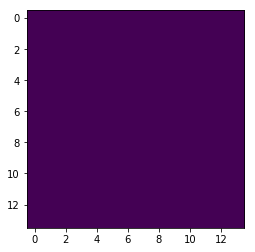

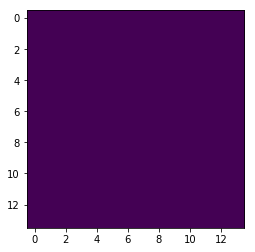

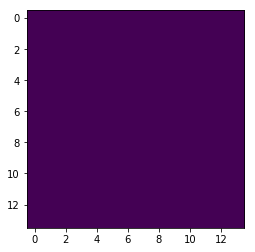

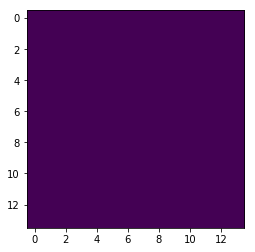

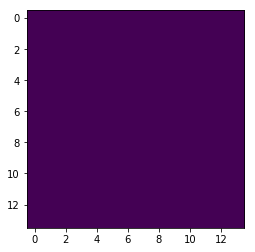

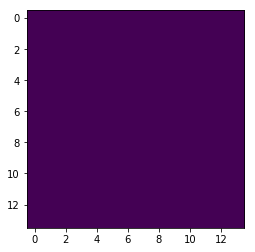

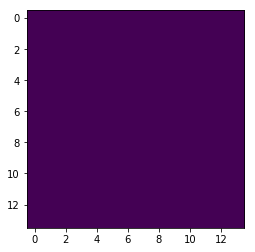

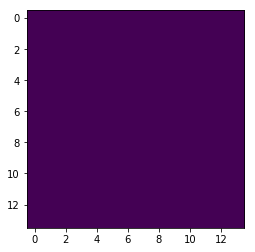

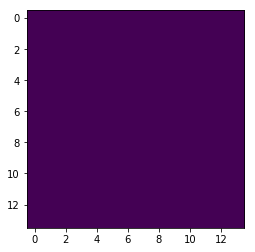

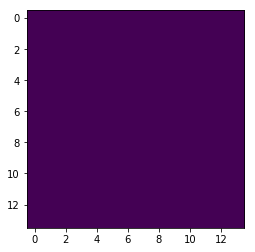

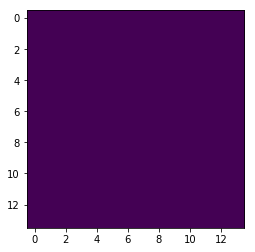

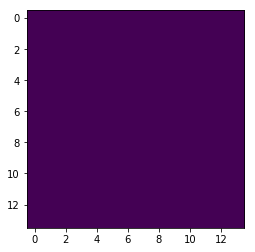

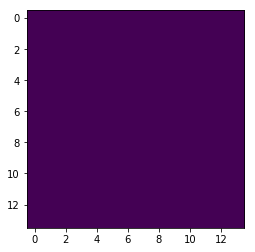

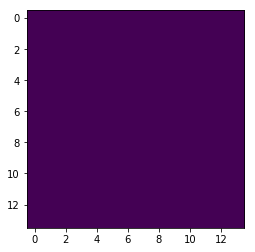

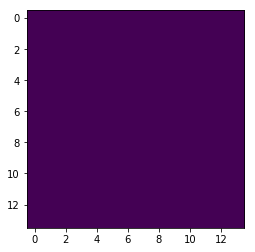

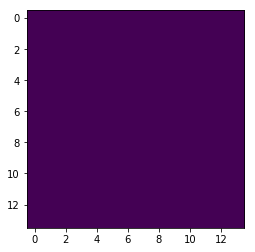

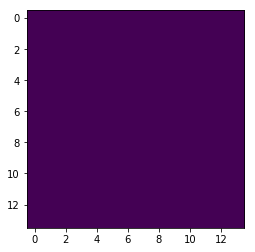

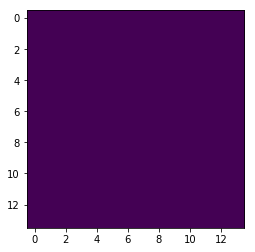

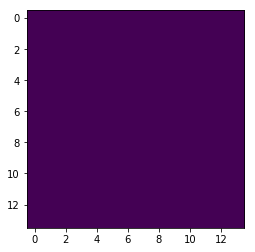

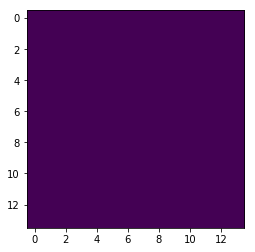

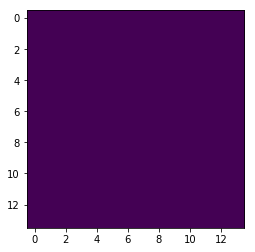

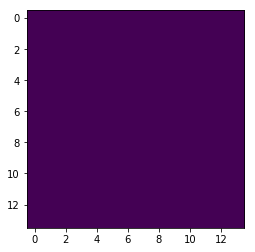

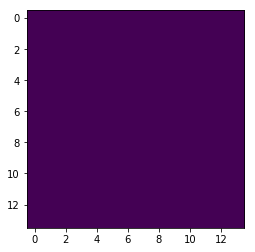

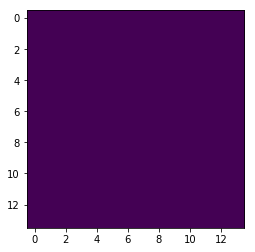

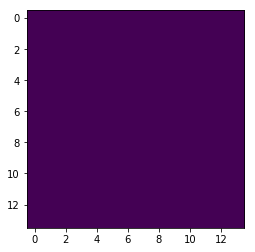

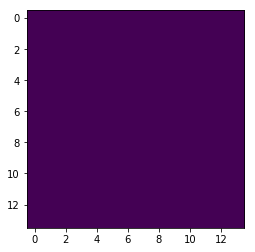

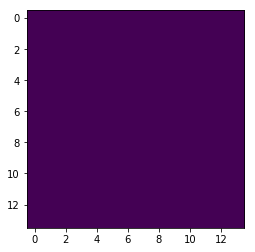

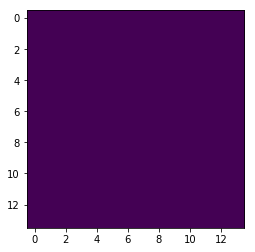

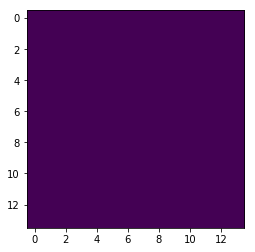

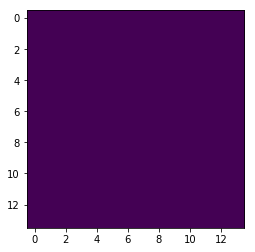

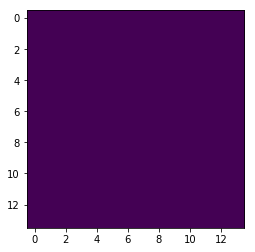

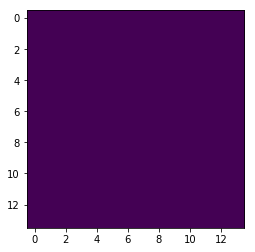

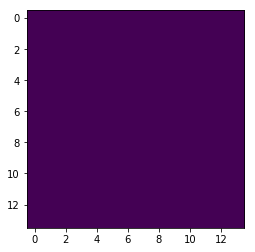

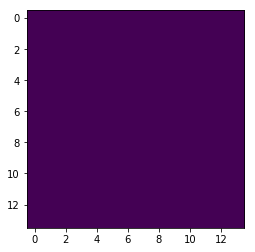

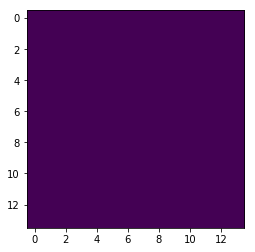

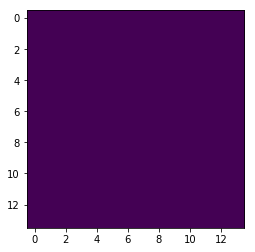

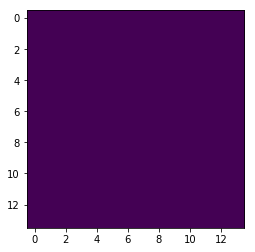

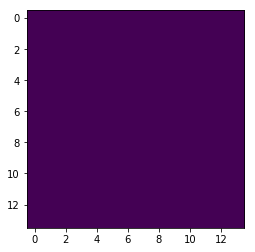

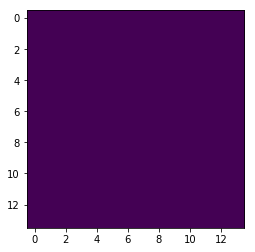

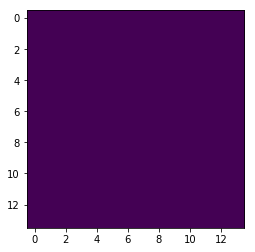

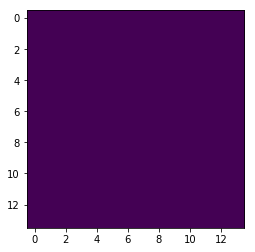

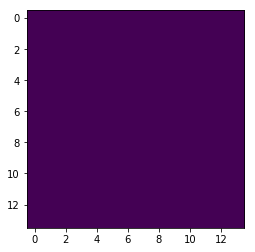

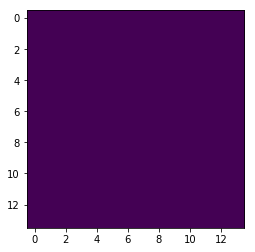

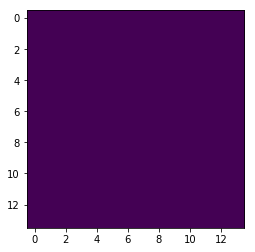

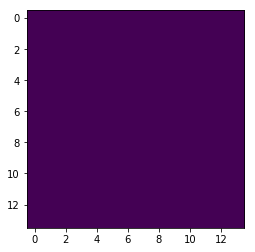

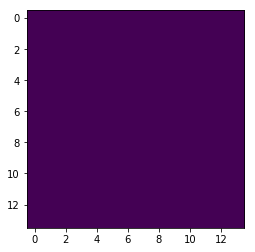

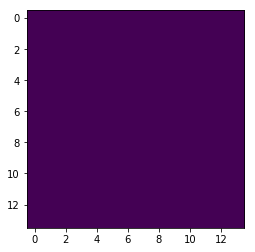

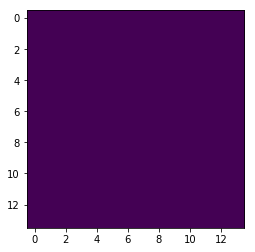

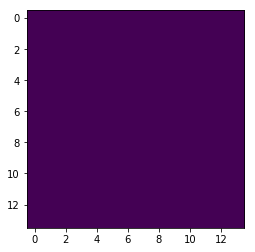

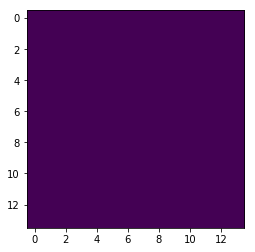

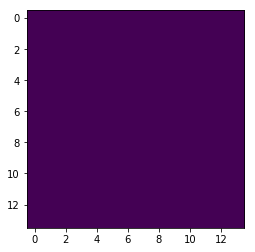

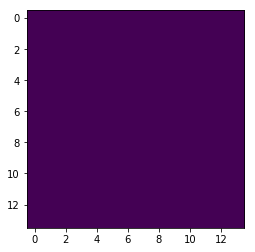

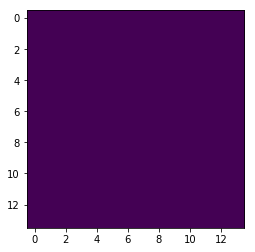

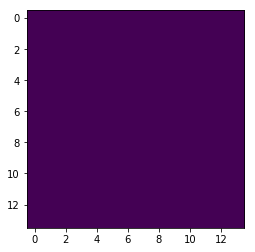

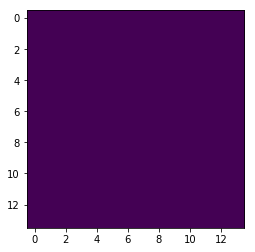

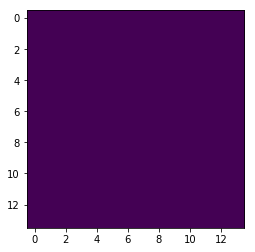

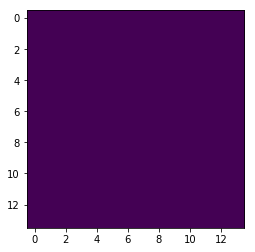

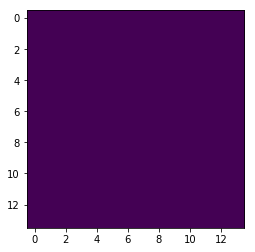

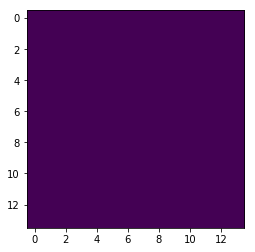

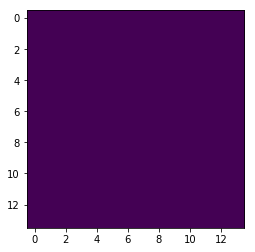

---------------vectormap------------------------


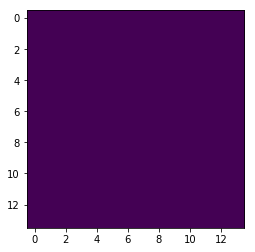

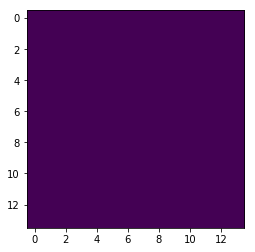

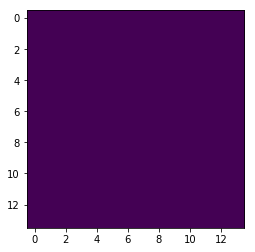

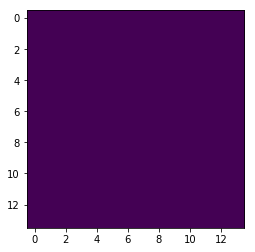

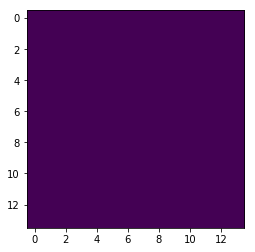

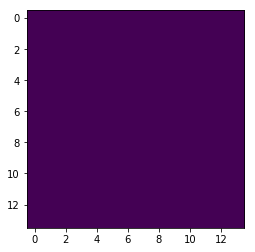

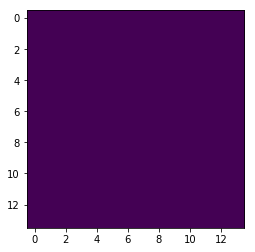

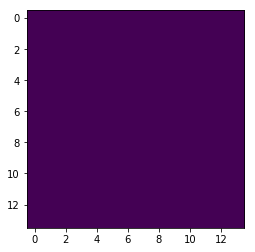

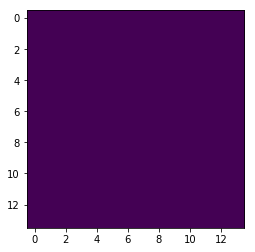

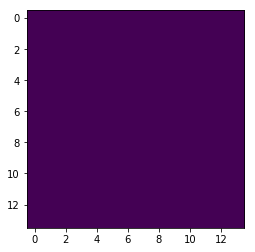

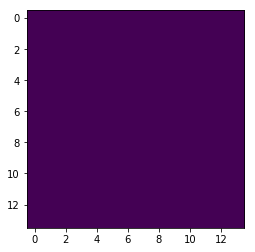

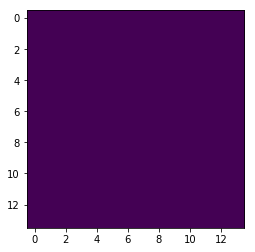

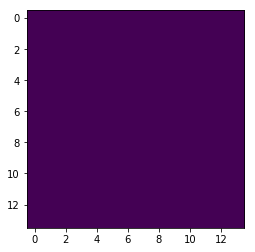

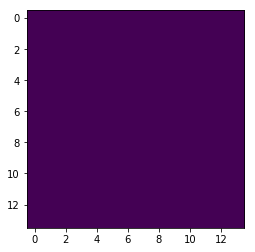

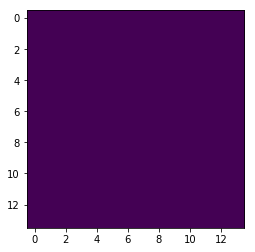

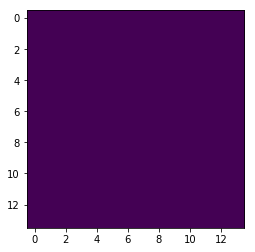

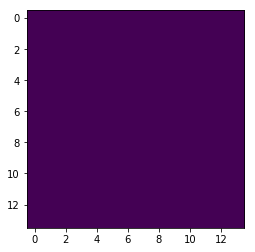

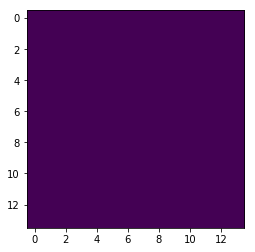

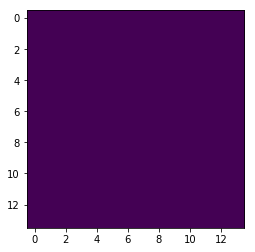

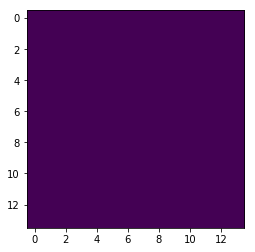

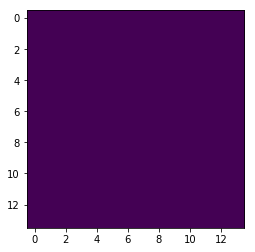

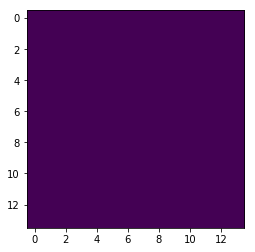

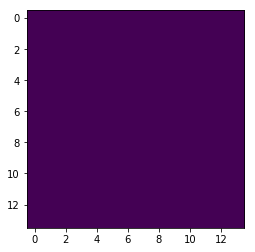

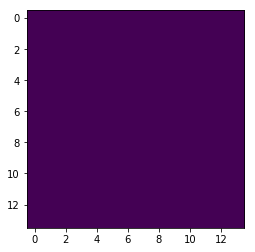

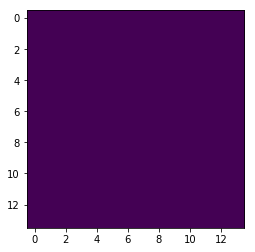

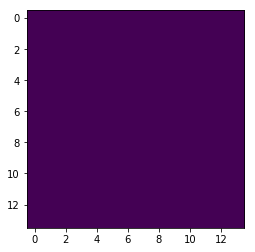

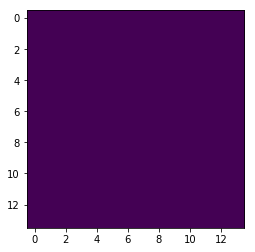

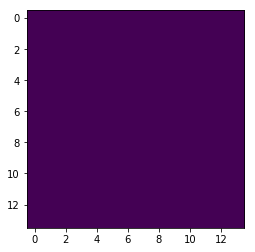

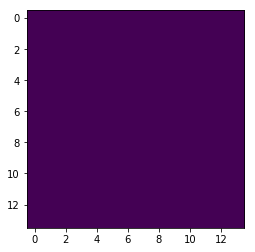

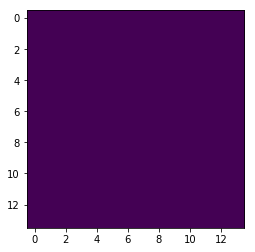

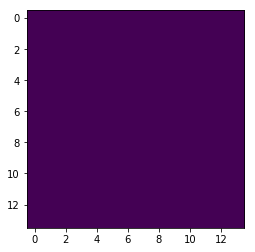

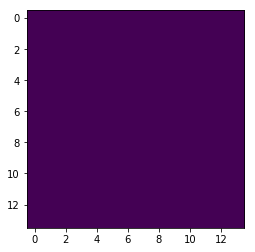

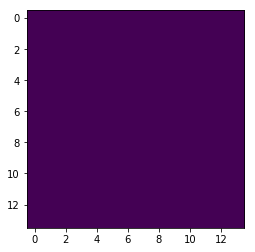

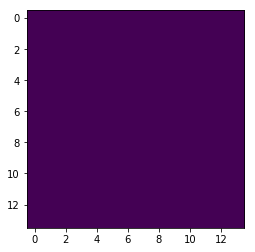

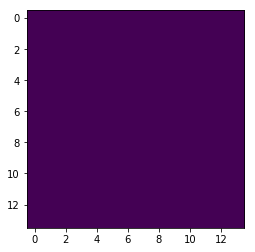

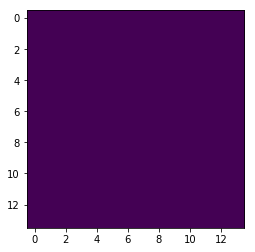

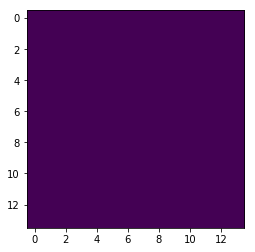

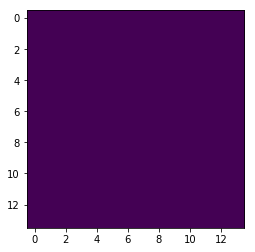

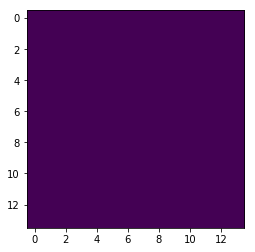

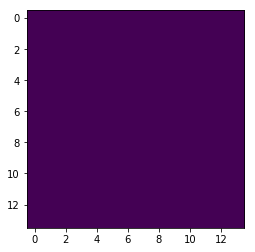

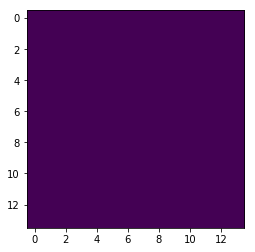

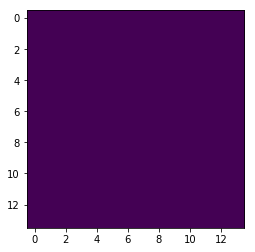

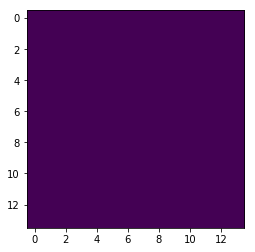

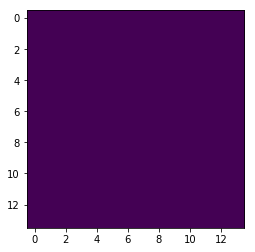

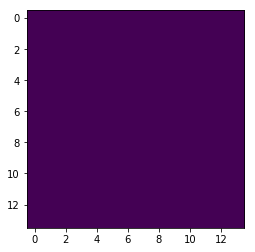

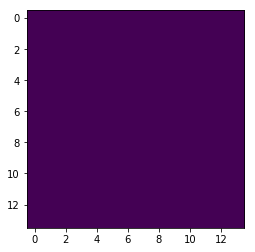

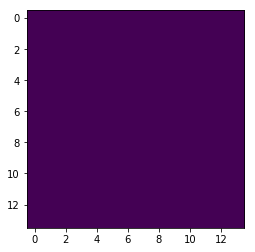

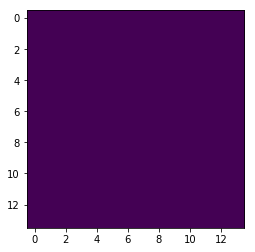

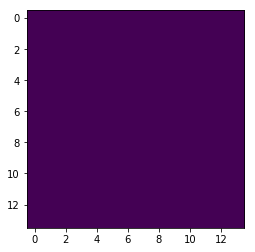

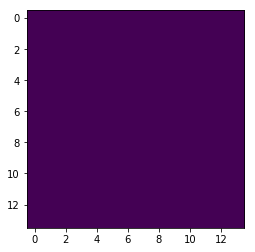

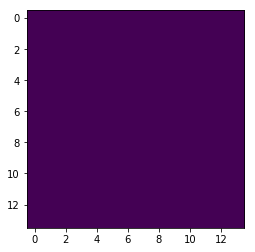

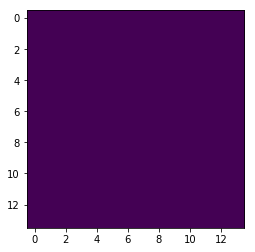

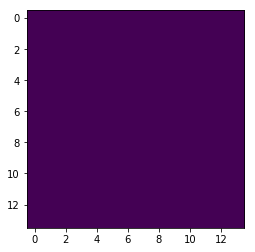

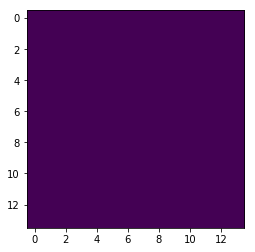

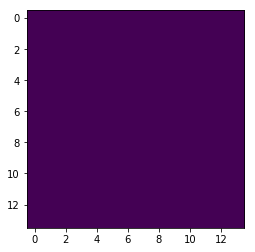

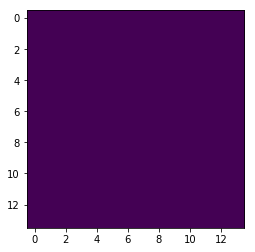

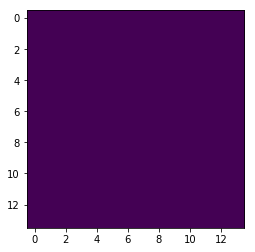

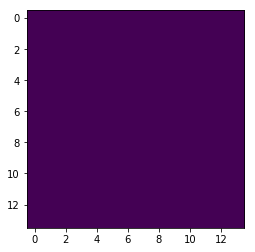

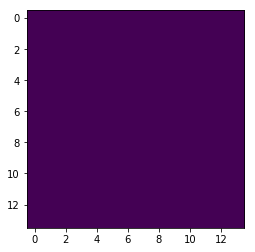

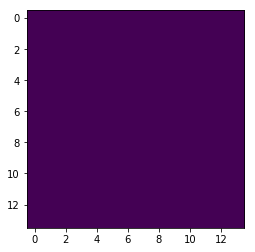

In [7]:
print("---------------heatmap------------------------")
for i in range(60):
    buffer = np.zeros((network_output_width, network_output_width))
    for j in range(16):
        buffer = buffer + __transpose_heatmap[i][j]
    plt.imshow(buffer)
    plt.show()
print("---------------vectormap------------------------")
for i in range(60):
    buffer = np.zeros((network_output_width, network_output_width))
    for j in range(32):
        buffer = buffer + __transpose_vectormap[i][j]
    plt.imshow(buffer)
    plt.show()

121frame video를 60frame 짜리로 만들기

In [ ]:
import cv2
cap = cv2.VideoCapture('./video/1.avi')
video_data = []
i = 0
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
while(i != length):
    ret, frame = cap.read()
    #gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (112, 112))
    video_data.append(frame)
    i = i + 1
np.shape(video_data)

In [ ]:
_60_frame_video = []
for i in range(60):
    _60_frame_video.append(video_data[i])

In [ ]:
np.shape(_60_frame_video)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output3.avi',fourcc, 30.0, (112,112))

for i in range(60):
    out.write(_60_frame_video[i])
out.release()

In [ ]:
import cv2
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('./video/1.avi')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output3.avi',fourcc, 30.0, (112,112))
#while(True):
while(cap.isOpened()):
    ret, img_color = cap.read()
    #print(np.shape(img_color))
    #img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    #img_gray = cv2.resize(img_gray, (112, 112))
    print("1")
    # 캡쳐되지 않은 경우 처리
    #out.write(img_gray)



    if ret == False:
        continue
    print("1")

    #27 -> esc
    if cv2.waitKey(1) & 0xFF == 27:
        break
    print("1")
cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
def conv_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value = 0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value = 1.0, dtype=tf.float32)

    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name = "moments")
    ema = tf.train.ExponentialMovingAverage(decay = 0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda:(ema_mean, ema_var))
    normed = tf.nn.batch_norm_with_global_normalization(x, mean, var, beta, gamma, 1e-3, True)
    return normed

In [ ]:
data = np.zeros((batch_size, num_video_frame, img_width, img_width, 3), dtype=np.float32)
for i in range(batch_size):
    for j in range(num_video_frame):
        for row in range(img_width):
            for col in range(img_width):
                for channel in range(3):
                    data[i][j][row][col][channel] = _batch_video_data[i][j][row][col][channel] / 255

In [ ]:
np.shape(_batch_video_data)

In [ ]:
for rgb_channel in range(3):
    for batch in range(1):
        for frame in range(60):
            a = np.asarray(_batch_video_data[batch][frame][:][:][rgb_channel])
            print(np.shape(a))

In [ ]:
for batch in range(1):
    for frame in range(60):
        _batch_video_data[batch][frame] = (_batch_video_data[batch][frame].astype(np.float32) / 256)

In [ ]:
_batch_video_data